## Connect Colab with Google drive and Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'

In [4]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('margaritakholostova/support-ii-dataset-with-critically-ill-patients', unzip=True)

# Critically Ill Patients Analysis and Prediction - Machine Learning Model

Dataset from Kaggle [Link](https://www.kaggle.com/datasets/margaritakholostova/support-ii-dataset-with-critically-ill-patients)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Reading `columns_descriptions` Dataset

In [6]:
features = pd.read_excel('/content/columns_descriptions.xlsx')
print(features.shape)
features.head()


(48, 5)


adlp  Feature Categorical Unnamed: 3  \
0   adls  Feature  Continuous        NaN   
1  adlsc  Feature  Continuous        NaN   
2    age  Feature  Continuous        Age   
3    alb  Feature  Continuous        NaN   
4    aps  Feature  Continuous        NaN   

  Index of Activities of Daily Living (ADL) of the patient, filled out by the patient. Higher values indicate more chance of survival, measured at day 3.  
0  Index of Activities of Daily Living (ADL) of t...                                                                                                       
1               Imputed ADL Calibrated to Surrogate.                                                                                                       
2                       Age of the patients in years                                                                                                       
3            serum albumin levels measured at day 3.                                                                                                       
4  APACHE III day 3 physiology score (no coma, im...

#### Shifting header of dataset as a entry

In [7]:
features.loc[-1] = features.columns
features.index = features.index + 1
features = features.sort_index()
features = features.reset_index(drop=True)


#### Checking for the dataset uniqueness of some columns

In [8]:
print(features.adlp.unique())
print(features.Feature.unique())
print(features.Categorical.unique())
print(features['Unnamed: 3'].unique())

['adlp' 'adls' 'adlsc' 'age' 'alb' 'aps' 'avtisst' 'bili' 'bun' 'ca'
 'charges' 'crea' 'd.time' 'death' 'dementia' 'diabetes' 'dnrday' 'dnr'
 'dzclass' 'dzgroup' 'edu' 'glucose' 'hday' 'hospdead' 'hrt' 'id' 'income'
 'meanbp' 'num.co' 'pafi' 'ph' 'prg2m' 'prg6m' 'race' 'resp' 'scoma' 'sex'
 'sfdm2' 'slos' 'sod' 'sps' 'surv2m' 'surv6m' 'temp' 'totcst' 'totmcst'
 'urine' 'Variable Name' 'wblc']
['Feature' 'Other' 'Target' 'ID' 'Role']
['Categorical' 'Continuous' 'Integer' 'Binary' 'Type']
['Unnamed: 3' nan 'Age' 'Education Level' 'Income' 'Race' 'Sex'
 'Demographic']


#### Renaming the dataset columns

In [9]:
features.rename(columns={'adlp': 'feature_name'},inplace=True)
features.rename(columns={'Feature': 'type'}, inplace=True)
features.rename(columns={'Categorical': 'dtype'}, inplace=True)
features.rename(columns={'Unnamed: 3': 'category'}, inplace=True)
features.rename(columns={'Index of Activities of Daily Living (ADL) of the patient, filled out by the patient. Higher values indicate more chance of survival, measured at day 3.': 'description'}, inplace=True)


In [10]:
print(features.shape)
features.head()

(49, 5)


feature_name     type        dtype    category  \
0         adlp  Feature  Categorical  Unnamed: 3   
1         adls  Feature   Continuous         NaN   
2        adlsc  Feature   Continuous         NaN   
3          age  Feature   Continuous         Age   
4          alb  Feature   Continuous         NaN   

                                         description  
0  Index of Activities of Daily Living (ADL) of t...  
1  Index of Activities of Daily Living (ADL) of t...  
2               Imputed ADL Calibrated to Surrogate.  
3                       Age of the patients in years  
4            serum albumin levels measured at day 3.

#### Let's see the description of the features

In [11]:
for index, row in features.iterrows():
    print(f"{row['feature_name']} => {row['description']}")

adlp => Index of Activities of Daily Living (ADL) of the patient, filled out by the patient. Higher values indicate more chance of survival, measured at day 3.
adls => Index of Activities of Daily Living (ADL) of the patient, filled out by a surrogate (e.g. family member), measured at day 3. Higher values indicate more chance of survival.
adlsc => Imputed ADL Calibrated to Surrogate.
age => Age of the patients in years
alb => serum albumin levels measured at day 3.
aps => APACHE III day 3 physiology score (no coma, imp bun,uout for ph1)
avtisst => Average TISS score, days 3-25, where Therapeutic Intervention Scoring System (TISS) is a method for calculating costs in the intensive care unit (ICU) and intermediate care unit (IMCU).
bili => bilirubin levels measured at day 3.
bun => Blood urea nitrogen levels measured at day 3.
ca => Whether the patient has cancer (yes), whether it has spread out (metastatic), or if it is healthy (no).
charges => Hospital charges
crea => serum creatinine 

## Reading `support2` Dataset

In [12]:
data = pd.read_csv('/content/support2.csv')
print(data.shape)
data.head()


(9105, 47)


age  death     sex  hospdead  slos  d.time            dzgroup  \
1  62.84998      0    male         0     5    2029        Lung Cancer   
2  60.33899      1  female         1     4       4          Cirrhosis   
3  52.74698      1  female         0    17      47          Cirrhosis   
4  42.38498      1  female         0     3     133        Lung Cancer   
5  79.88495      0  female         0    16    2029  ARF/MOSF w/Sepsis   

              dzclass  num.co   edu  ...      crea    sod        ph  glucose  \
1              Cancer       0  11.0  ...  1.199951  141.0  7.459961      NaN   
2  COPD/CHF/Cirrhosis       2  12.0  ...  5.500000  132.0  7.250000      NaN   
3  COPD/CHF/Cirrhosis       2  12.0  ...  2.000000  134.0  7.459961      NaN   
4              Cancer       2  11.0  ...  0.799927  139.0       NaN      NaN   
5            ARF/MOSF       1   NaN  ...  0.799927  143.0  7.509766      NaN   

   bun  urine adlp  adls                sfdm2  adlsc  
1  NaN    NaN  7.0   7.0                  NaN    7.0  
2  NaN    NaN  NaN   1.0     <2 mo. follow-up    1.0  
3  NaN    NaN  1.0   0.0     <2 mo. follow-up    0.0  
4  NaN    NaN  0.0   0.0  no(M2 and SIP pres)    0.0  
5  NaN    NaN  NaN   2.0  no(M2 and SIP pres)    2.0  

[5 rows x 47 columns]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9105 entries, 1 to 9105
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       9105 non-null   float64
 1   death     9105 non-null   int64  
 2   sex       9105 non-null   object 
 3   hospdead  9105 non-null   int64  
 4   slos      9105 non-null   int64  
 5   d.time    9105 non-null   int64  
 6   dzgroup   9105 non-null   object 
 7   dzclass   9105 non-null   object 
 8   num.co    9105 non-null   int64  
 9   edu       7471 non-null   float64
 10  income    6123 non-null   object 
 11  scoma     9104 non-null   float64
 12  charges   8933 non-null   float64
 13  totcst    8217 non-null   float64
 14  totmcst   5630 non-null   float64
 15  avtisst   9023 non-null   float64
 16  race      9063 non-null   object 
 17  sps       9104 non-null   float64
 18  aps       9104 non-null   float64
 19  surv2m    9104 non-null   float64
 20  surv6m    9104 non-null   floa

In [14]:
data.isnull().sum()

age            0
death          0
sex            0
hospdead       0
slos           0
d.time         0
dzgroup        0
dzclass        0
num.co         0
edu         1634
income      2982
scoma          1
charges      172
totcst       888
totmcst     3475
avtisst       82
race          42
sps            1
aps            1
surv2m         1
surv6m         1
hday           0
diabetes       0
dementia       0
ca             0
prg2m       1649
prg6m       1633
dnr           30
dnrday        30
meanbp         1
wblc         212
hrt            1
resp           1
temp           1
pafi        2325
alb         3372
bili        2601
crea          67
sod            1
ph          2284
glucose     4500
bun         4352
urine       4862
adlp        5641
adls        2867
sfdm2       1400
adlsc          0
dtype: int64

## Performing EDA

#### Convert the categorical data into numerical data

In [15]:
data.select_dtypes(include=['object']).columns.tolist()


['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr', 'sfdm2']

In [16]:
data.dzgroup.unique()

array(['Lung Cancer', 'Cirrhosis', 'ARF/MOSF w/Sepsis', 'Coma', 'CHF',
       'Colon Cancer', 'COPD', 'MOSF w/Malig'], dtype=object)

In [17]:
data.dzclass.unique()

array(['Cancer', 'COPD/CHF/Cirrhosis', 'ARF/MOSF', 'Coma'], dtype=object)

In [18]:
data.income.unique()

array(['$11-$25k', 'under $11k', nan, '$25-$50k', '>$50k'], dtype=object)

In [19]:
data.race.unique()

array(['other', 'white', 'black', 'hispanic', 'asian', nan], dtype=object)

In [20]:
data.ca.unique()

array(['metastatic', 'no', 'yes'], dtype=object)

In [21]:
data.dnr.unique()

array(['no dnr', nan, 'dnr after sadm', 'dnr before sadm'], dtype=object)

In [22]:
data.sfdm2.unique()

array([nan, '<2 mo. follow-up', 'no(M2 and SIP pres)', 'SIP>=30',
       'adl>=4 (>=5 if sur)', 'Coma or Intub'], dtype=object)

In [23]:
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()

data['sex']= encode.fit_transform(data['sex'])
data['dzgroup']= encode.fit_transform(data['dzgroup'])
data['dzclass']= encode.fit_transform(data['dzclass'])
data['income']= encode.fit_transform(data['income']) # having null values
data['race']= encode.fit_transform(data['race']) # having null values
data['ca']= encode.fit_transform(data['ca'])
data['dnr']= encode.fit_transform(data['dnr']) # having null values
data['sfdm2']= encode.fit_transform(data['sfdm2']) # having null values


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9105 entries, 1 to 9105
Data columns (total 47 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       9105 non-null   float64
 1   death     9105 non-null   int64  
 2   sex       9105 non-null   int64  
 3   hospdead  9105 non-null   int64  
 4   slos      9105 non-null   int64  
 5   d.time    9105 non-null   int64  
 6   dzgroup   9105 non-null   int64  
 7   dzclass   9105 non-null   int64  
 8   num.co    9105 non-null   int64  
 9   edu       7471 non-null   float64
 10  income    9105 non-null   int64  
 11  scoma     9104 non-null   float64
 12  charges   8933 non-null   float64
 13  totcst    8217 non-null   float64
 14  totmcst   5630 non-null   float64
 15  avtisst   9023 non-null   float64
 16  race      9105 non-null   int64  
 17  sps       9104 non-null   float64
 18  aps       9104 non-null   float64
 19  surv2m    9104 non-null   float64
 20  surv6m    9104 non-null   floa

In [25]:
data.head()

age  death  sex  hospdead  slos  d.time  dzgroup  dzclass  num.co  \
1  62.84998      0    1         0     5    2029        6        2       0   
2  60.33899      1    0         1     4       4        3        1       2   
3  52.74698      1    0         0    17      47        3        1       2   
4  42.38498      1    0         0     3     133        6        2       2   
5  79.88495      0    0         0    16    2029        0        0       1   

    edu  ...      crea    sod        ph  glucose  bun  urine  adlp  adls  \
1  11.0  ...  1.199951  141.0  7.459961      NaN  NaN    NaN   7.0   7.0   
2  12.0  ...  5.500000  132.0  7.250000      NaN  NaN    NaN   NaN   1.0   
3  12.0  ...  2.000000  134.0  7.459961      NaN  NaN    NaN   1.0   0.0   
4  11.0  ...  0.799927  139.0       NaN      NaN  NaN    NaN   0.0   0.0   
5   NaN  ...  0.799927  143.0  7.509766      NaN  NaN    NaN   NaN   2.0   

   sfdm2  adlsc  
1      5    7.0  
2      0    1.0  
3      0    0.0  
4      4    0.0  
5      4    2.0  

[5 rows x 47 columns]

#### Filling the missing values of the dataset according to the 10 years range of age.

In [26]:
def fillNullByAge(row, columns, medians):
    for col in columns:
        if pd.isnull(row[col]):
            age_bin_value = int(row['age_bin']) if not pd.isnull(row['age_bin']) else -1
            row[col] = medians[medians['age_bin'] == age_bin_value][col].iloc[0]
    return row

def fillValues(data, columns):
    data.sort_values('age', inplace=True)
    age_bins = np.arange(0, 100, 10)
    data['age_bin'] = pd.cut(data['age'], bins=age_bins, labels=False, include_lowest=True, right=False)
    data['age_bin'].fillna(-1, inplace=True)

    medians = data.groupby('age_bin')[columns].mean().reset_index()

    data = data.apply(lambda row: fillNullByAge(row, columns, medians), axis=1)
    data.drop('age_bin', axis=1, inplace=True)

    return data


In [27]:
data = fillValues(data, list(data.columns))

In [28]:
data.isnull().sum()

age         0
death       0
sex         0
hospdead    0
slos        0
d.time      0
dzgroup     0
dzclass     0
num.co      0
edu         0
income      0
scoma       0
charges     0
totcst      0
totmcst     0
avtisst     0
race        0
sps         0
aps         0
surv2m      0
surv6m      0
hday        0
diabetes    0
dementia    0
ca          0
prg2m       0
prg6m       0
dnr         0
dnrday      0
meanbp      0
wblc        0
hrt         0
resp        0
temp        0
pafi        0
alb         0
bili        0
crea        0
sod         0
ph          0
glucose     0
bun         0
urine       0
adlp        0
adls        0
sfdm2       0
adlsc       0
dtype: int64

In [29]:
data.describe()

age        death          sex     hospdead         slos  \
count  9105.000000  9105.000000  9105.000000  9105.000000  9105.000000   
mean     62.650823     0.681054     0.562878     0.259198    17.863042   
std      15.593710     0.466094     0.496058     0.438219    22.006440   
min      18.041990     0.000000     0.000000     0.000000     3.000000   
25%      52.797000     0.000000     0.000000     0.000000     6.000000   
50%      64.856990     1.000000     1.000000     0.000000    11.000000   
75%      73.998960     1.000000     1.000000     1.000000    20.000000   
max     101.847960     1.000000     1.000000     1.000000   343.000000   

            d.time      dzgroup      dzclass       num.co          edu  ...  \
count  9105.000000  9105.000000  9105.000000  9105.000000  9105.000000  ...   
mean    478.449863     2.230093     0.822625     1.868644    11.735790  ...   
std     560.383272     2.462660     0.922320     1.344409     3.130140  ...   
min       3.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%      26.000000     0.000000     0.000000     1.000000    11.000000  ...   
50%     233.000000     1.000000     1.000000     2.000000    12.000000  ...   
75%     761.000000     4.000000     1.000000     3.000000    12.621684  ...   
max    2029.000000     7.000000     3.000000     9.000000    31.000000  ...   

              crea          sod           ph      glucose          bun  \
count  9105.000000  9105.000000  9105.000000  9105.000000  9105.000000   
mean      1.770916   137.568521     7.415432   159.895559    32.348782   
std       1.679832     6.028995     0.069747    62.877353    19.363926   
min       0.099991   110.000000     6.829102     0.000000     1.000000   
25%       0.899902   134.000000     7.399414   133.000000    22.000000   
50%       1.199951   137.000000     7.417198   158.284854    32.337303   
75%       1.899902   141.000000     7.449219   162.163721    32.908518   
max      21.500000   181.000000     7.769531  1092.000000   300.000000   

             urine         adlp         adls        sfdm2        adlsc  
count  9105.000000  9105.000000  9105.000000  9105.000000  9105.000000  
mean   2193.650188     1.165364     1.638630     2.543767     1.888272  
std     995.754500     1.078517     1.855450     1.977488     2.003763  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%    2020.000000     1.000000     0.000000     0.000000     0.000000  
50%    2193.047502     1.132867     1.384615     3.000000     1.000000  
75%    2268.448117     1.170483     2.000000     4.000000     3.000000  
max    9000.000000     7.000000     7.000000     5.000000     7.073242  

[8 rows x 47 columns]

#### Let's plot the graph and see the distribution of the dataset

In [30]:
def plotGraph(col, bins=30, bandwidth=None):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

  sns.histplot(col, bins=bins, kde=True, color='skyblue', alpha=0.7, ax=axes[0])
  axes[0].set_title(f'Distribution of {col.name}')
  axes[0].set_xlabel(f'{col.name} values')
  axes[0].set_ylabel('Count')

  sns.kdeplot(col, color='blue', fill=True, bw_adjust=bandwidth if bandwidth is not None else 1.0, ax=axes[1])
  axes[1].set_title(f'Kernel Density Estimate (KDE) plot of {col.name}')
  axes[1].set_xlabel(f'{col.name} values')
  axes[1].set_ylabel('Density')

  sns.boxplot(x=col, color='lightgray', width=0.3, linewidth=2, fliersize=5, ax=axes[2])
  axes[2].set_title(f'Box Plot of {col.name}')
  axes[2].set_xlabel(f'{col.name} values')
  axes[2].set_ylabel('Value')

  plt.savefig(f'{col.name}_plot.jpg', format='jpg')

  plt.tight_layout()
  plt.show()


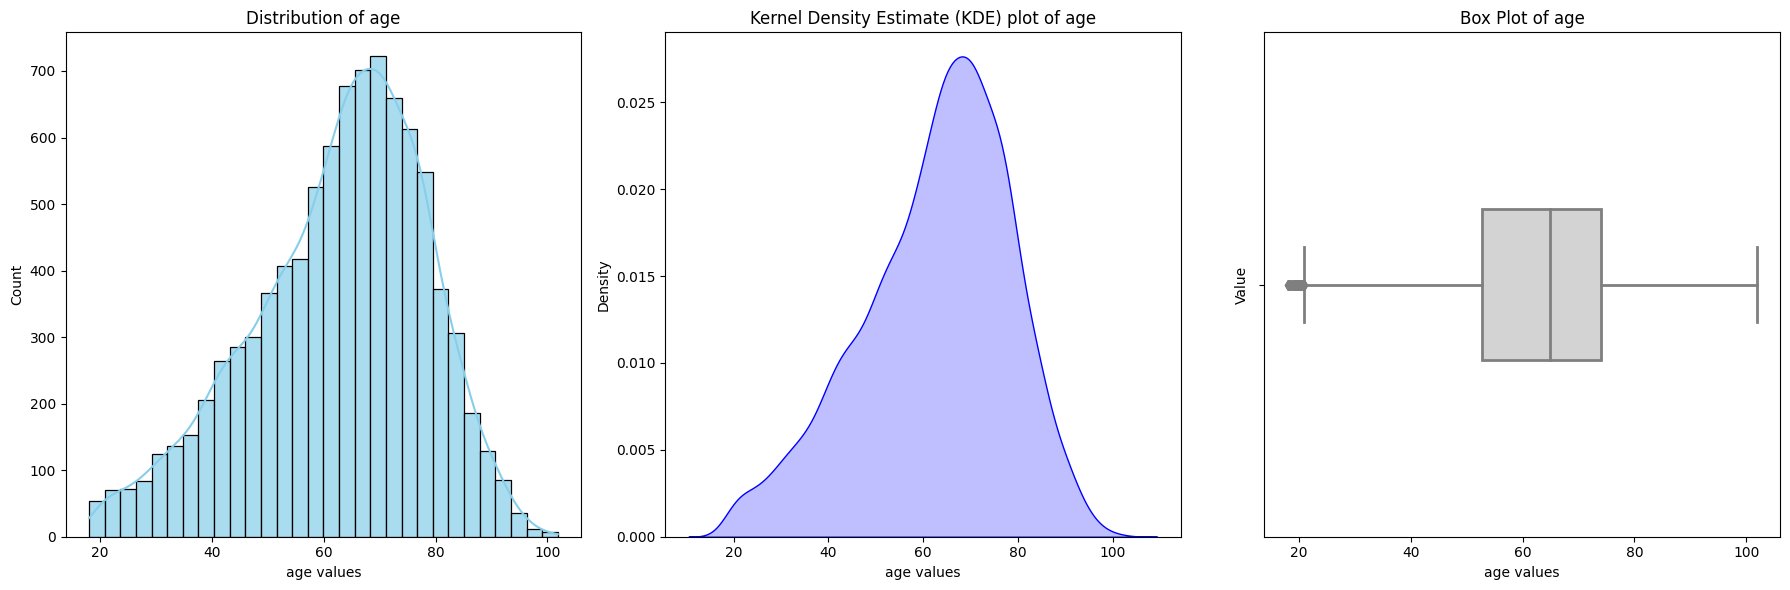

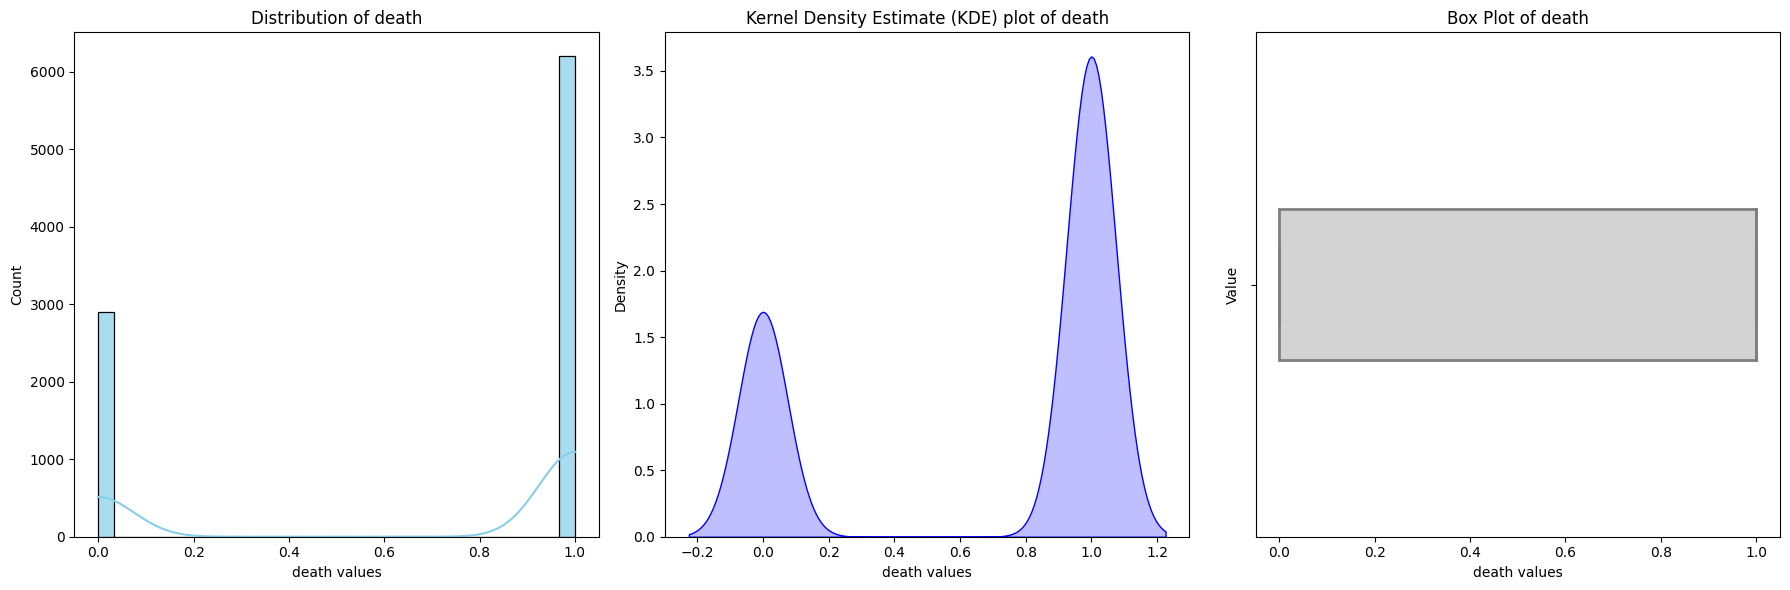

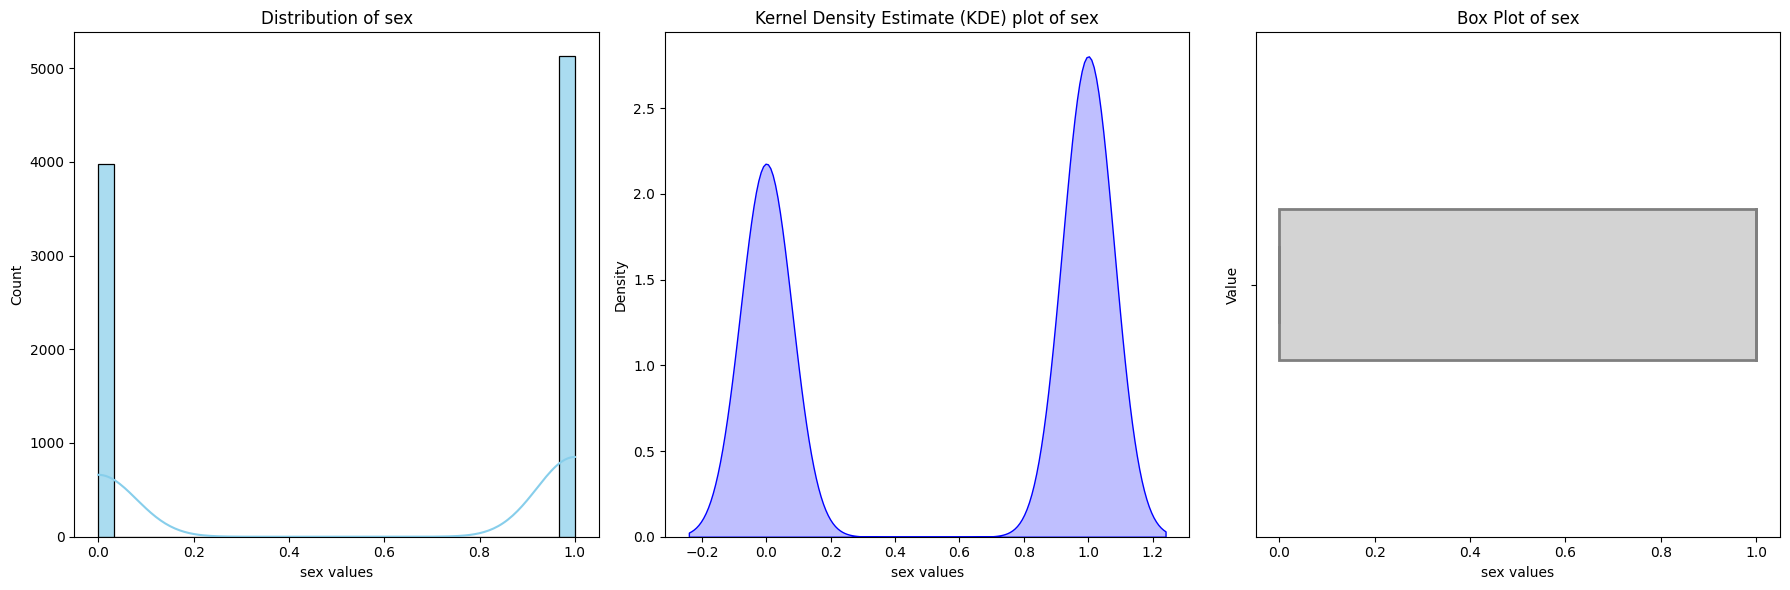

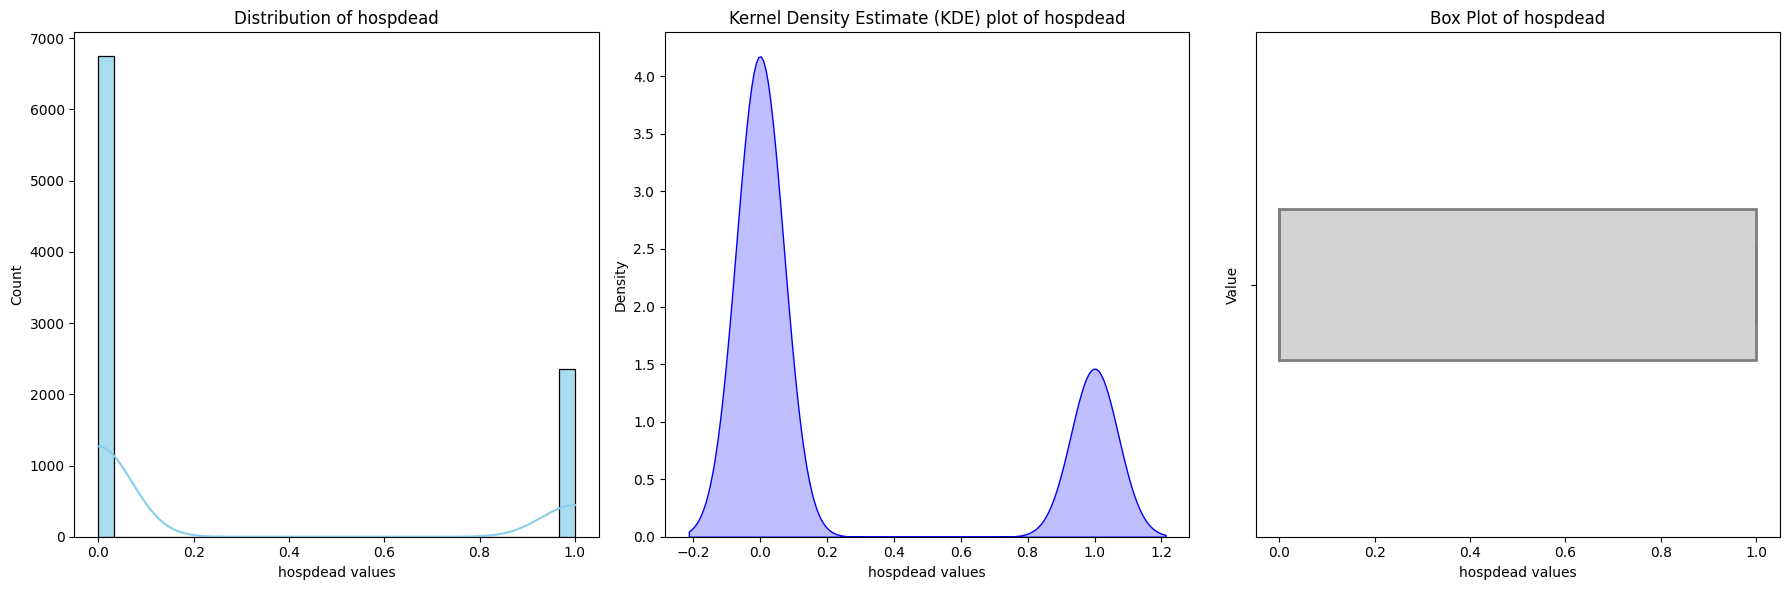

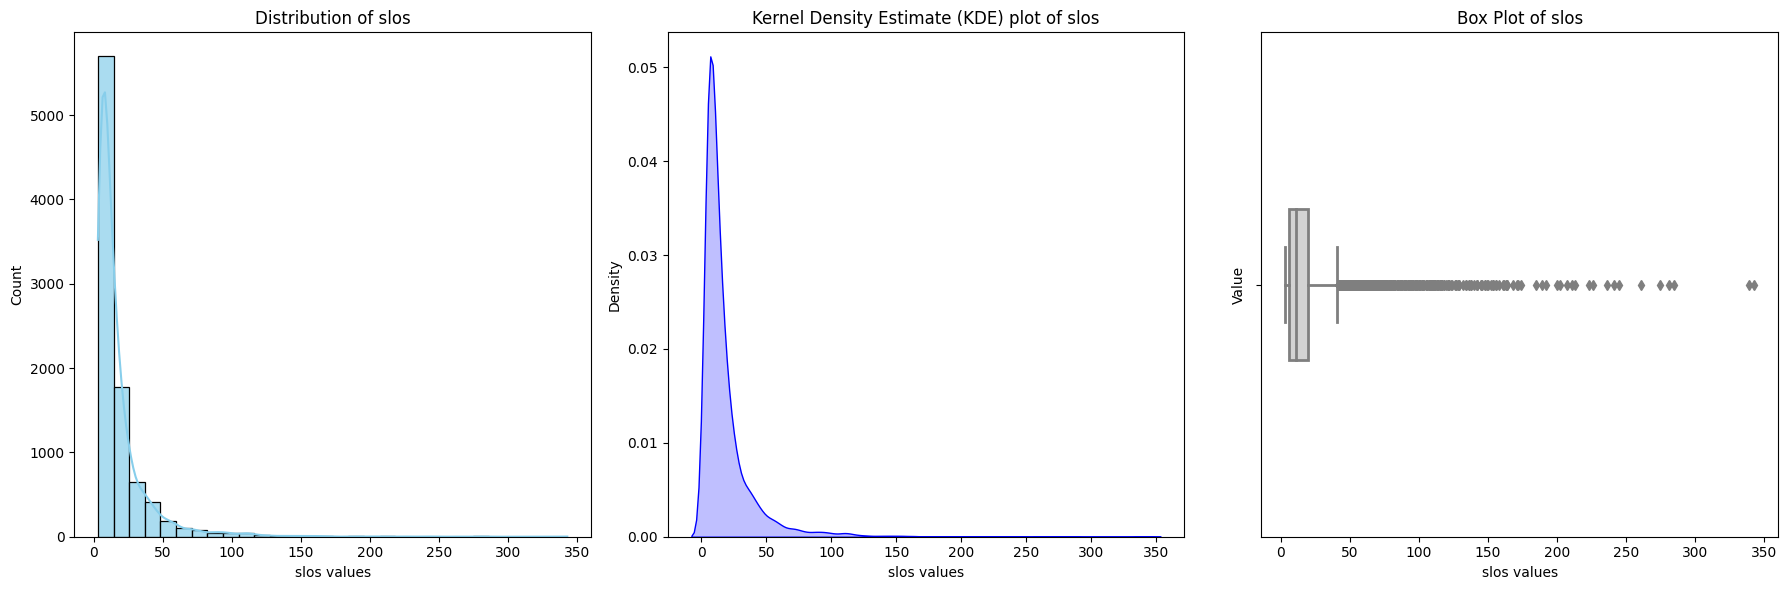

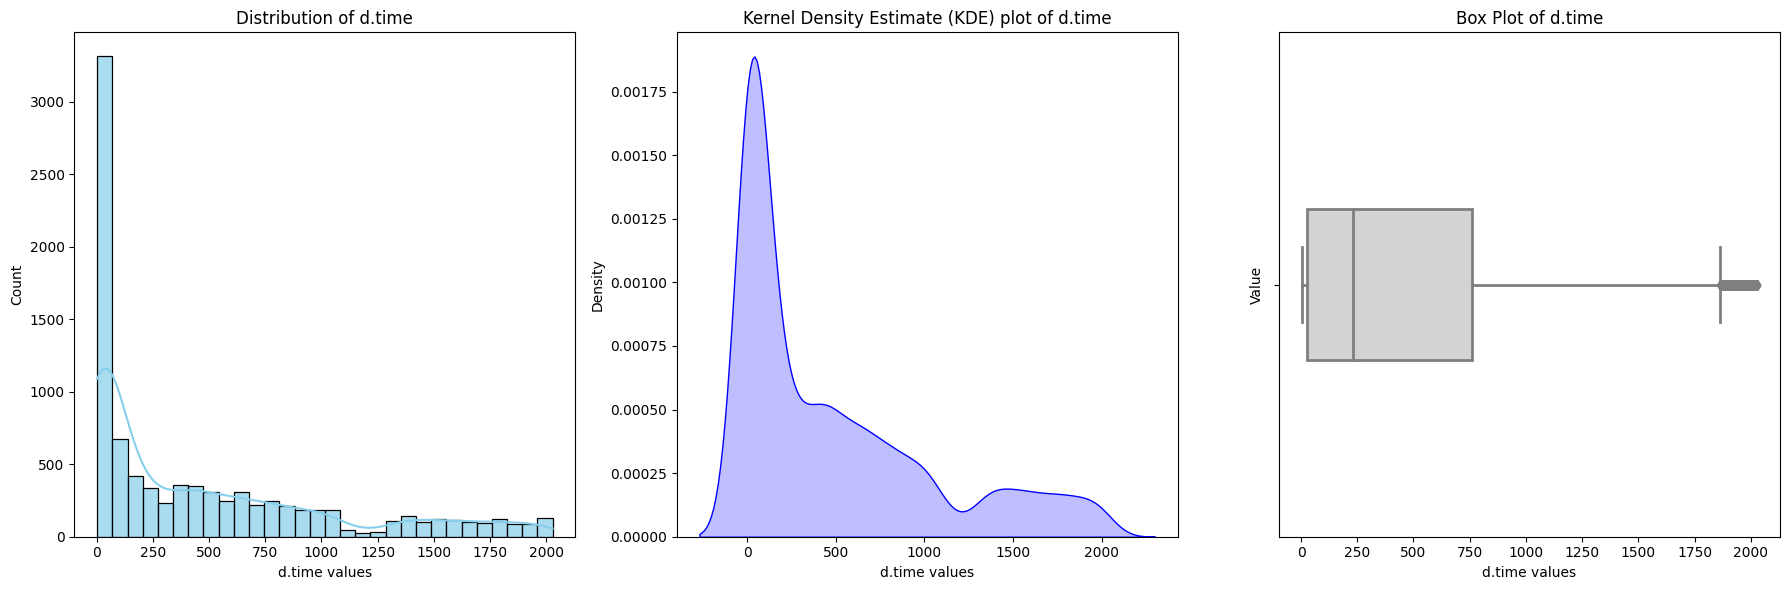

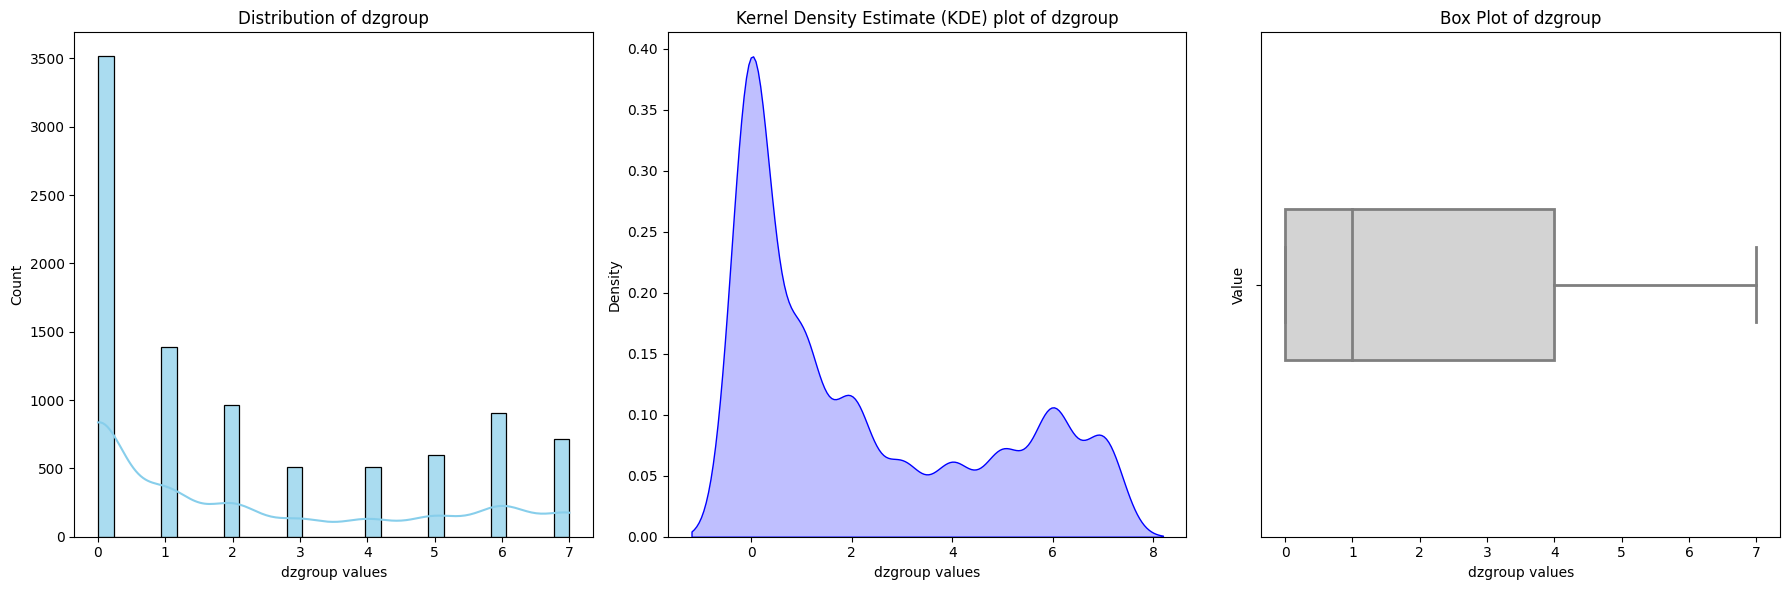

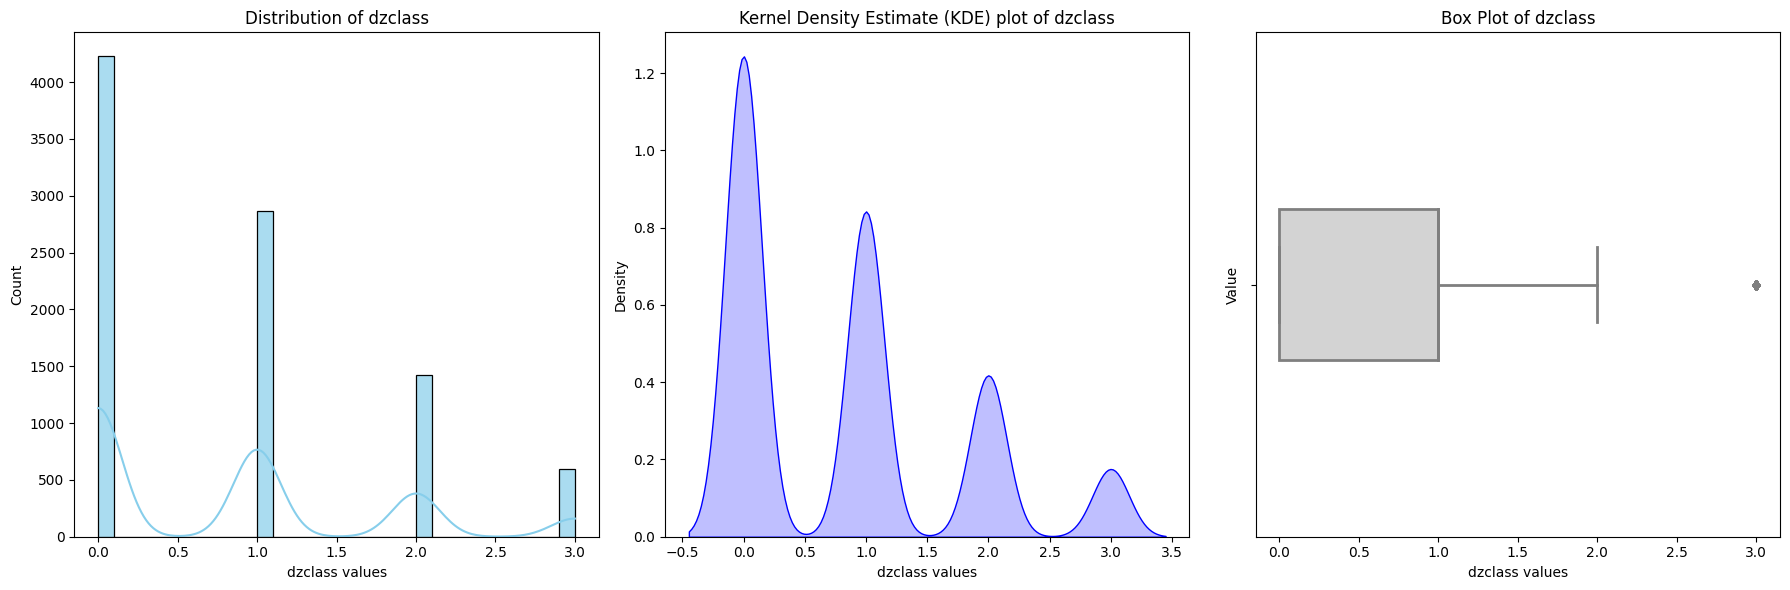

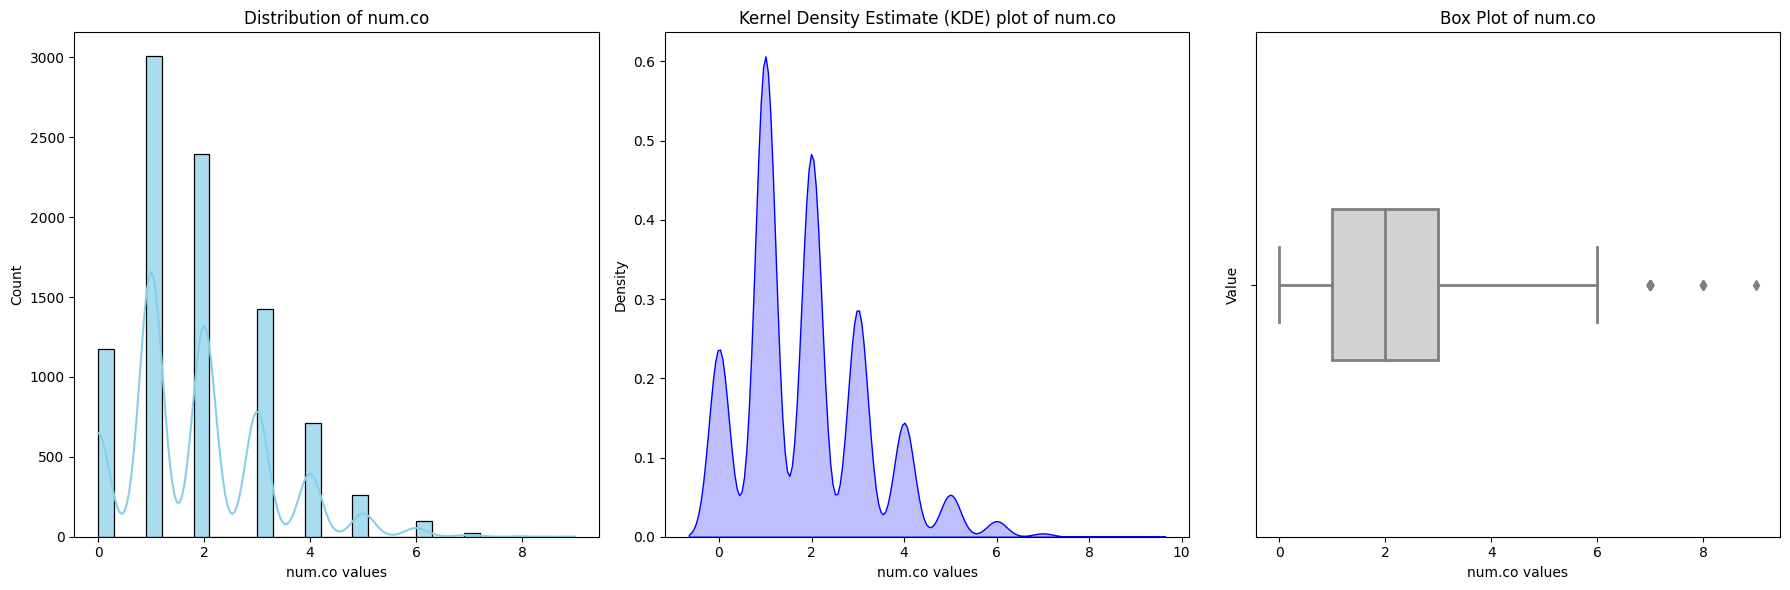

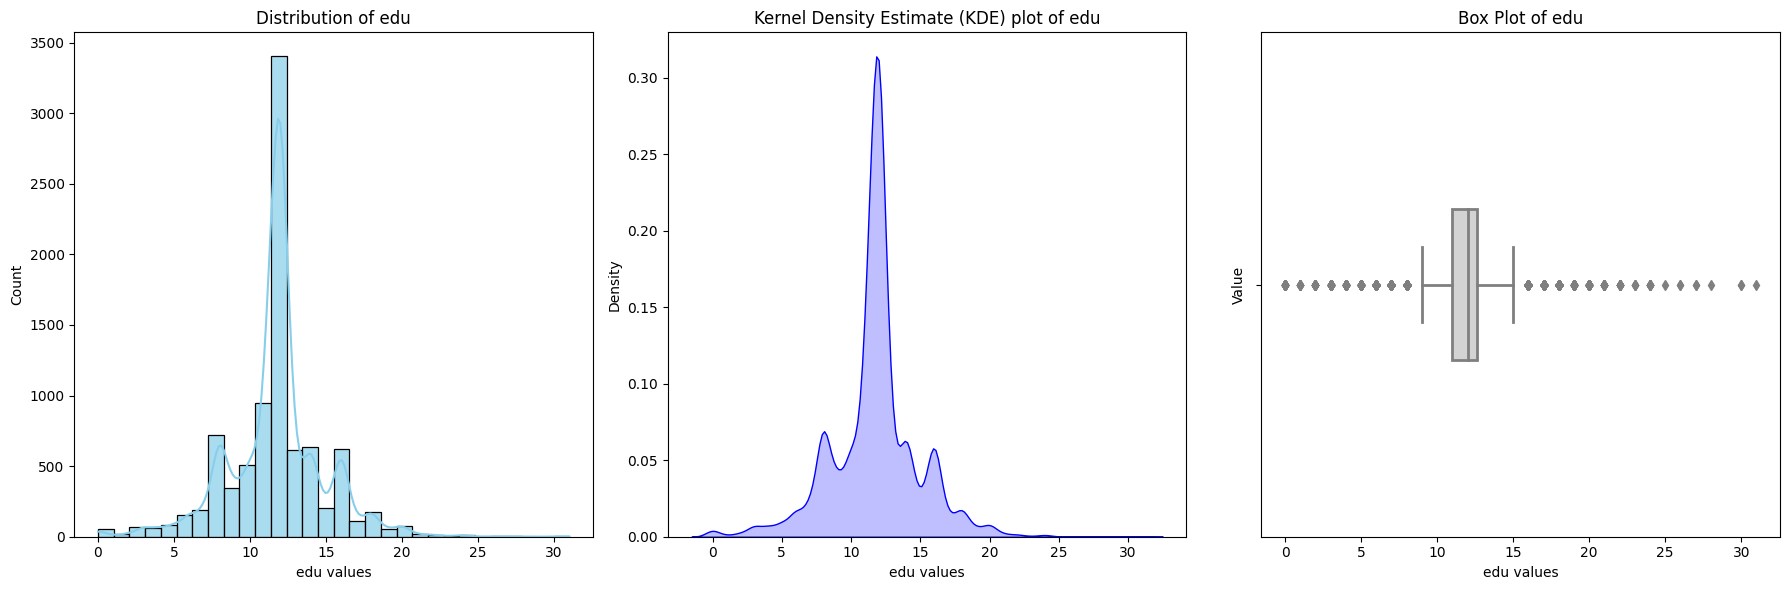

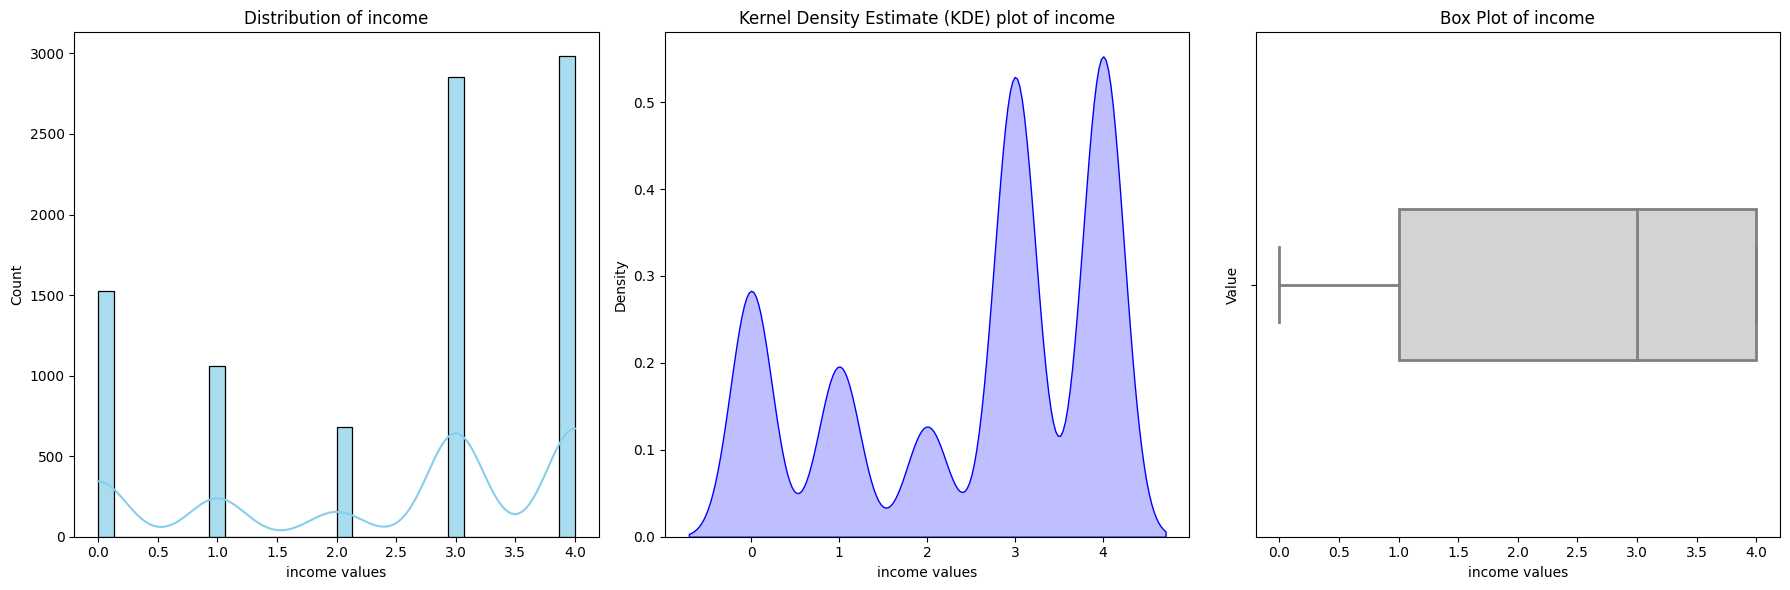

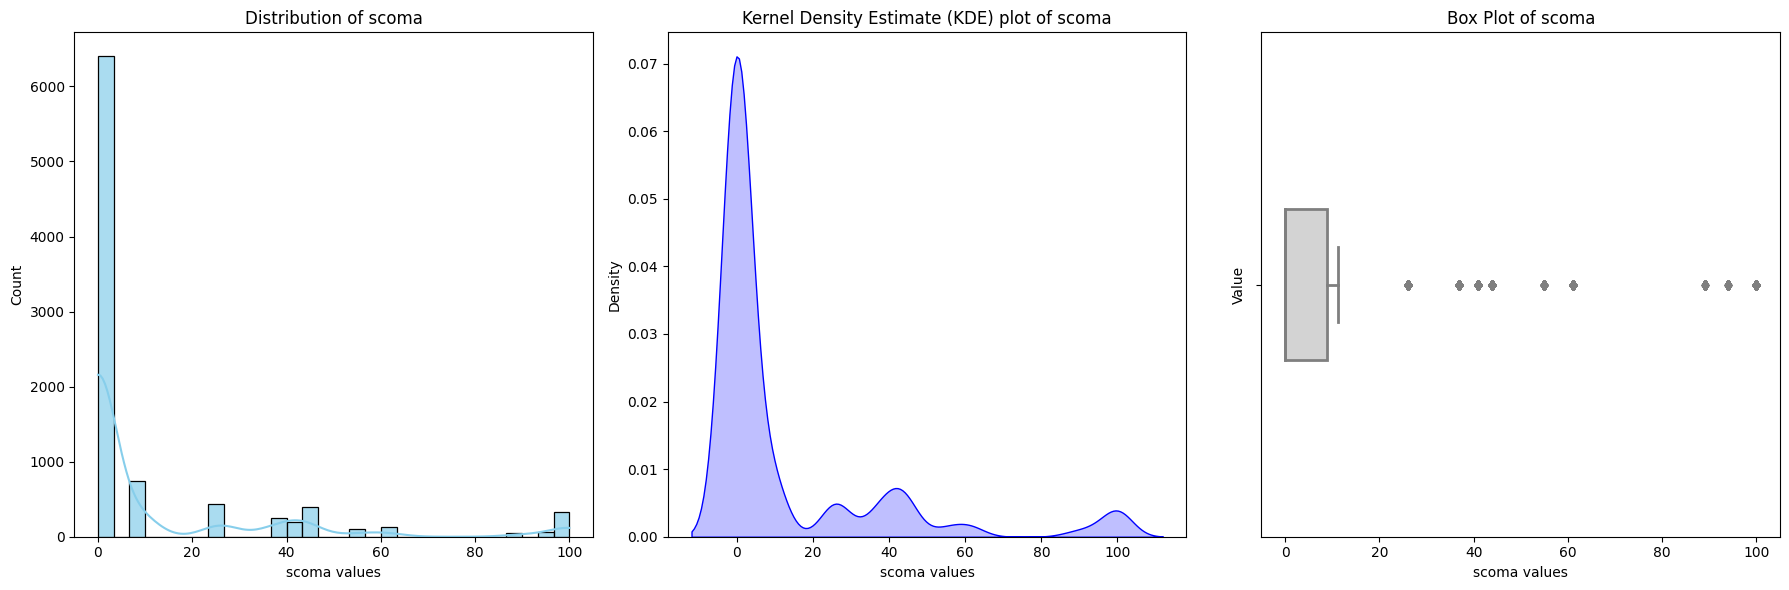

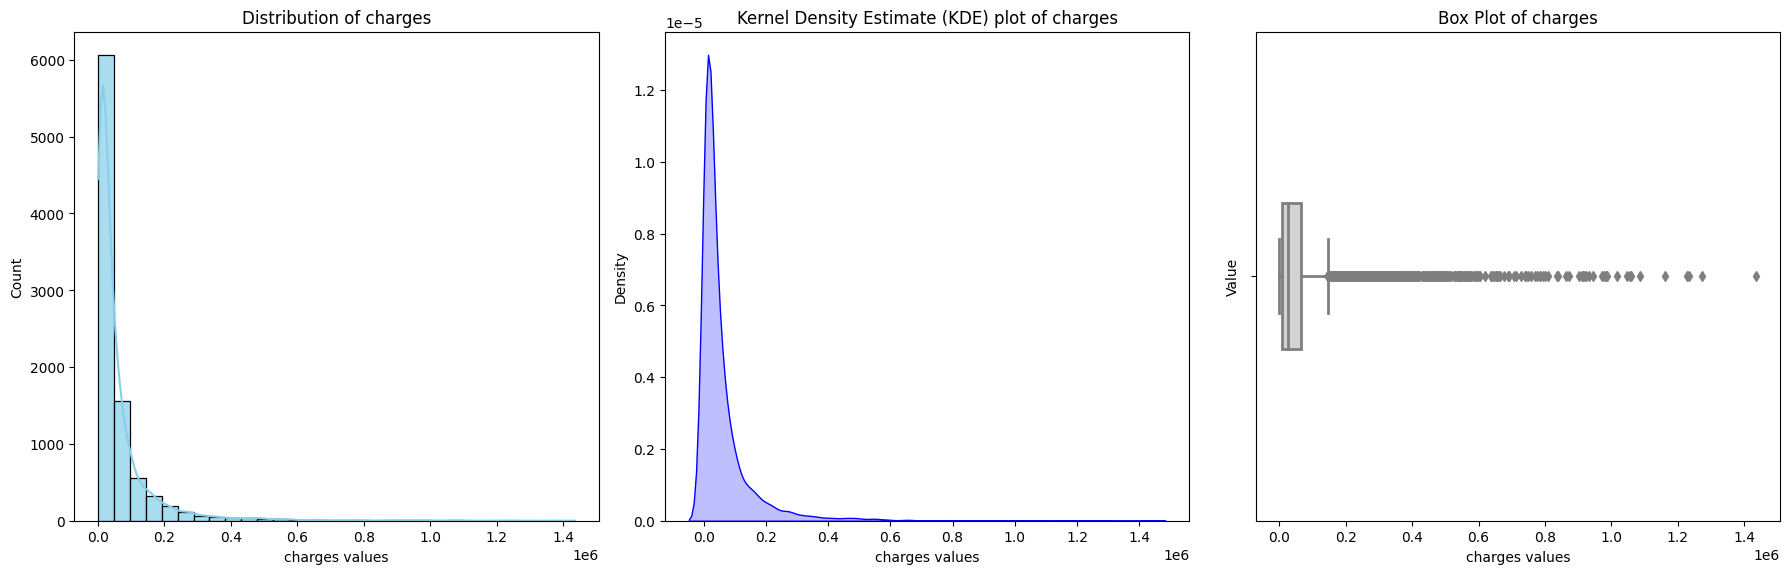

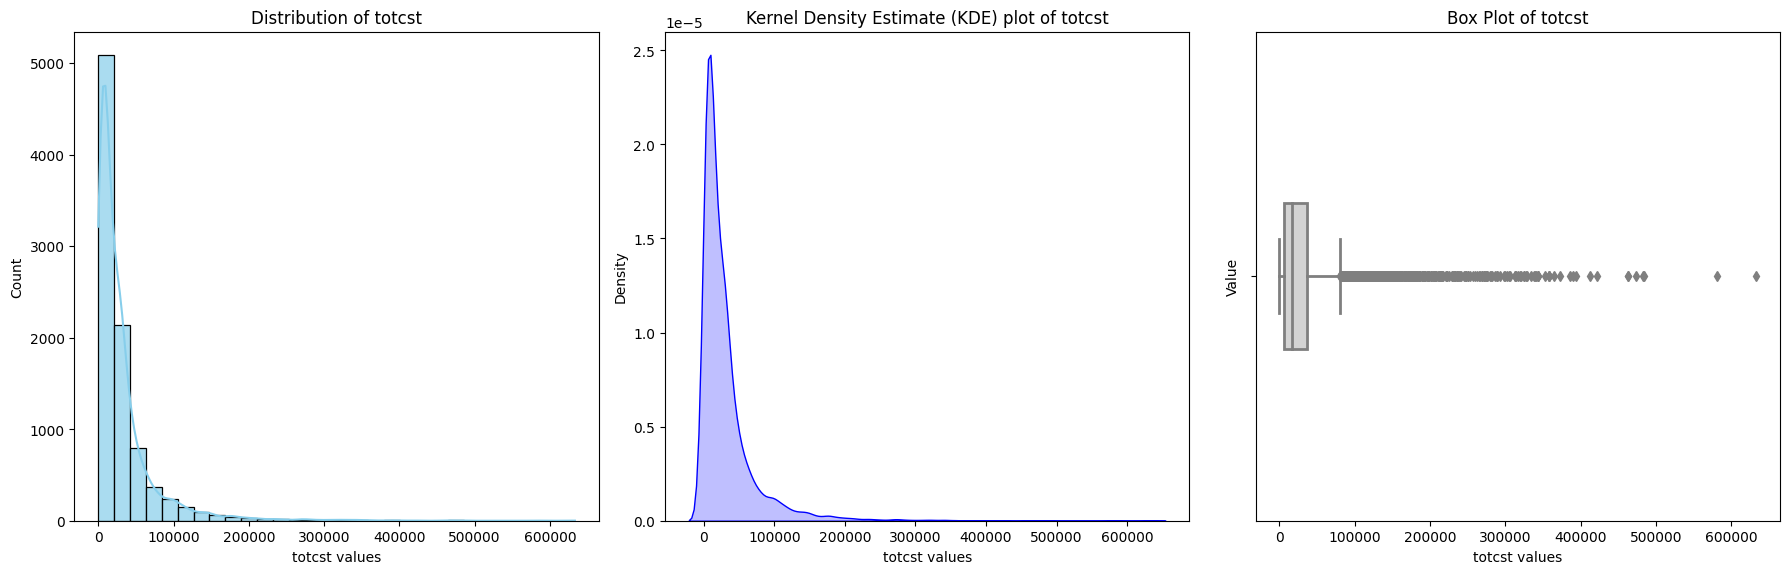

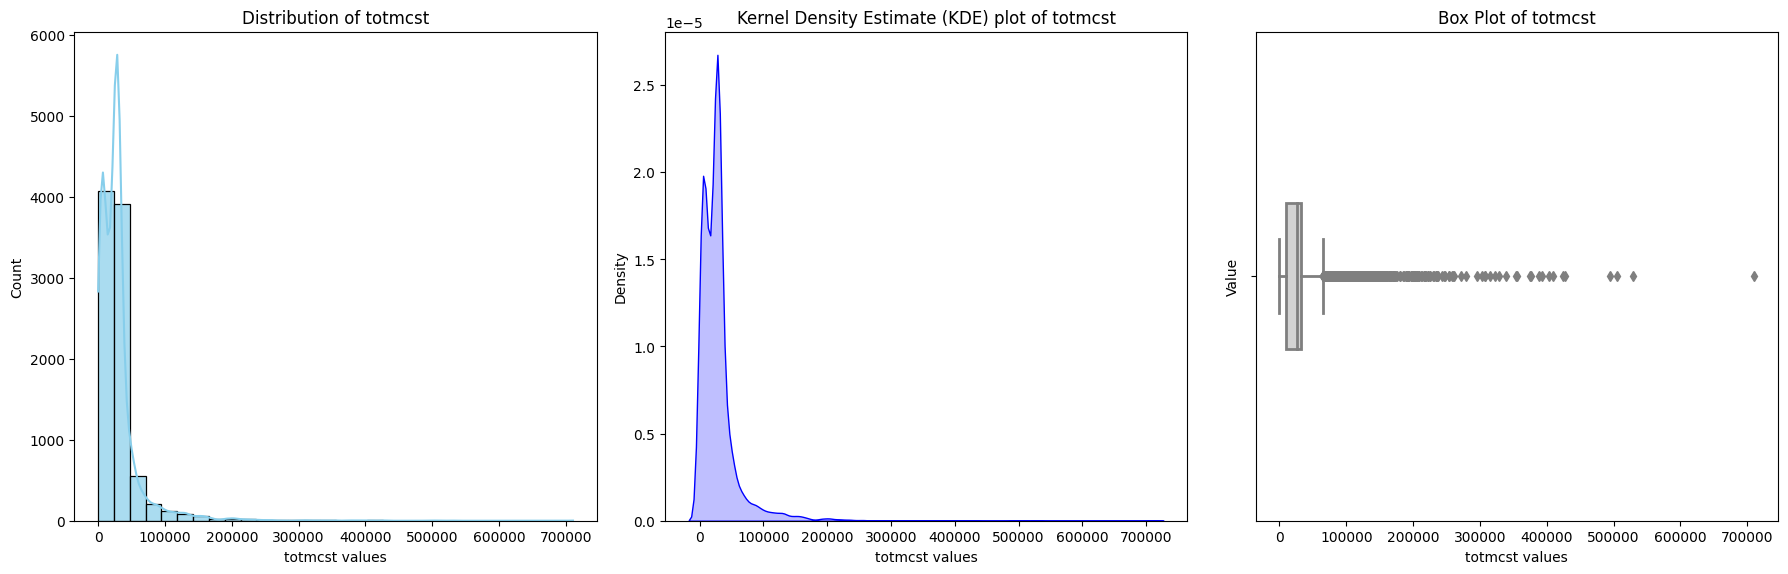

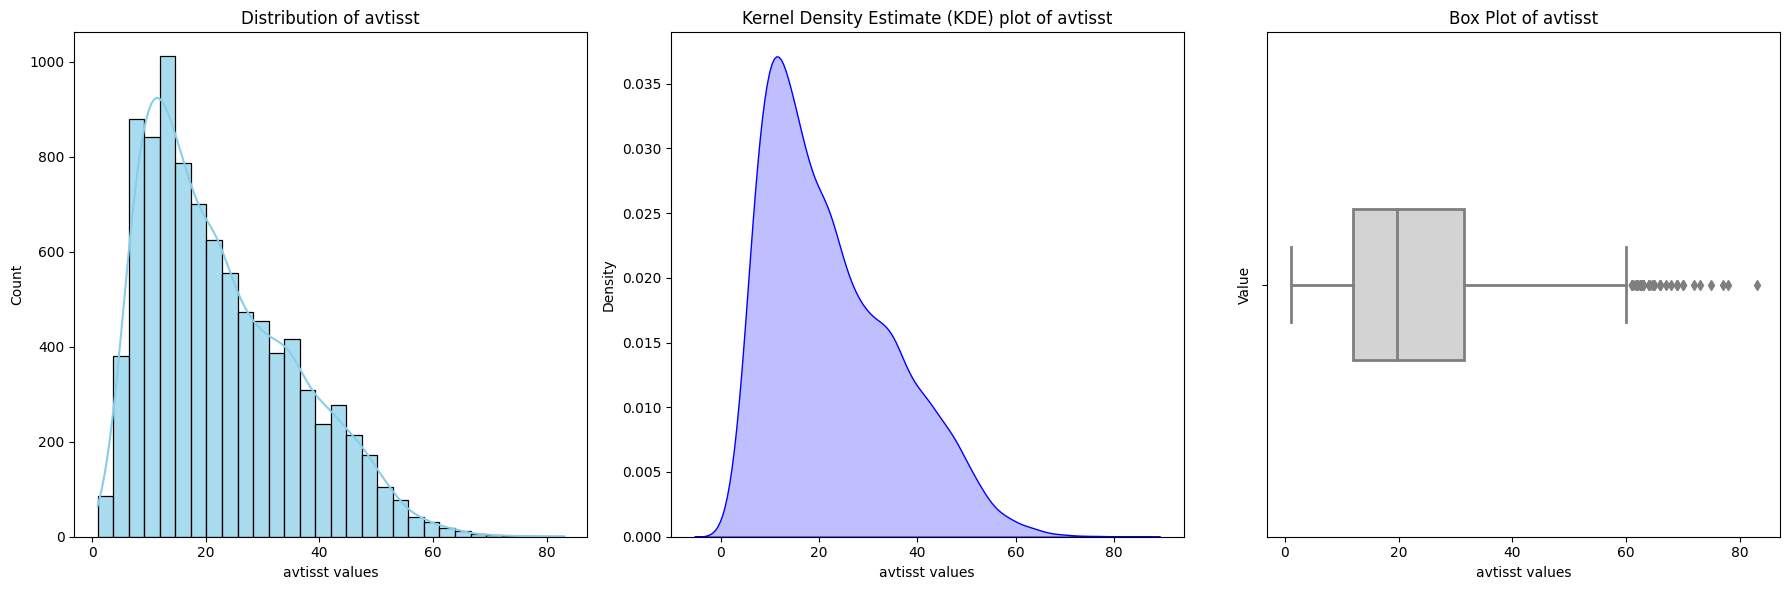

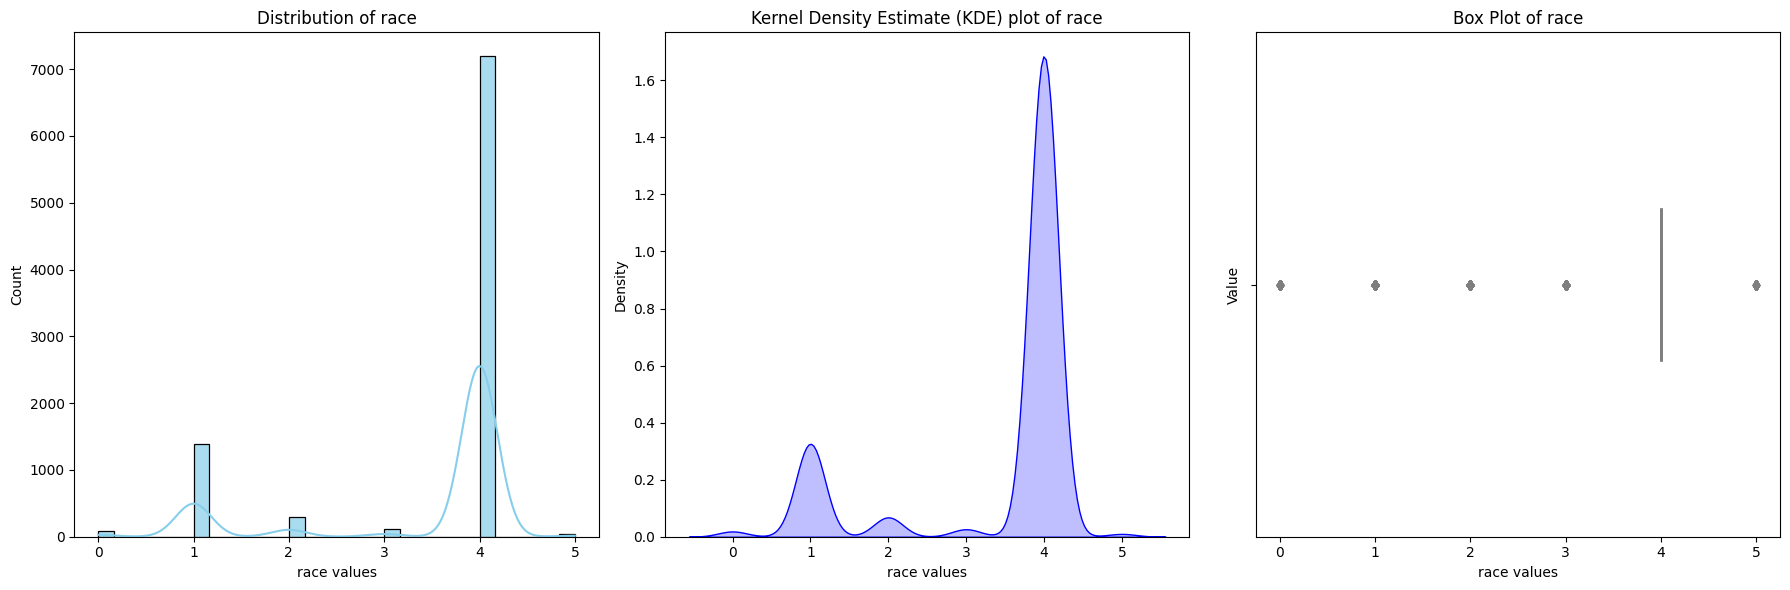

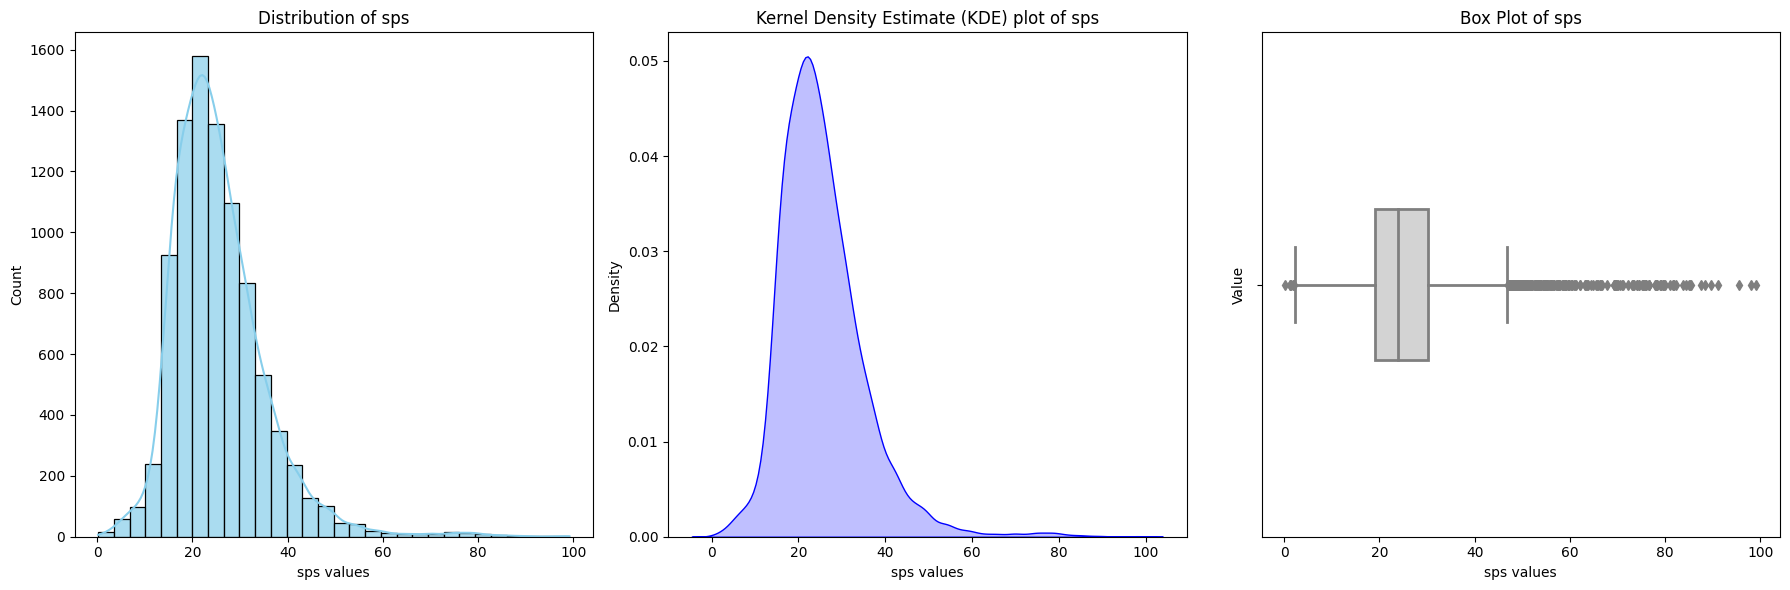

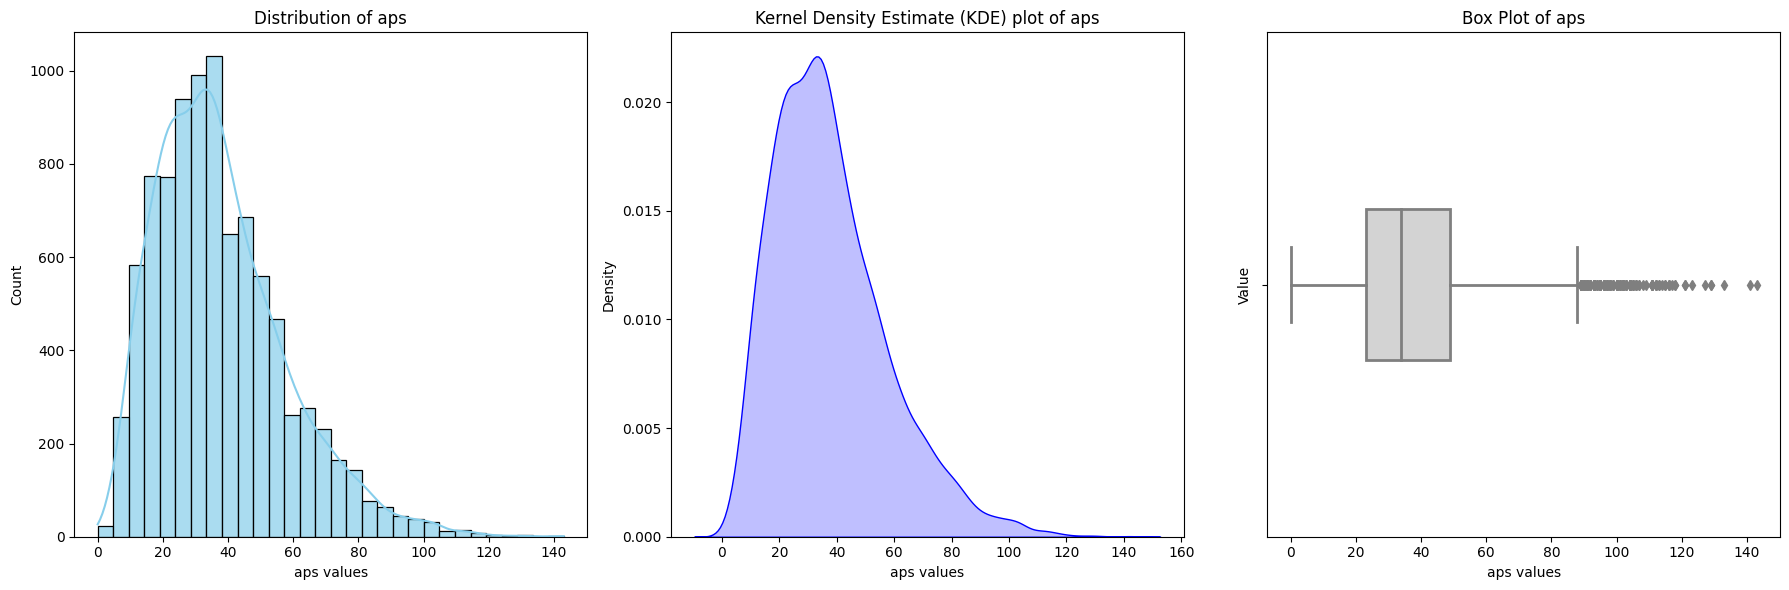

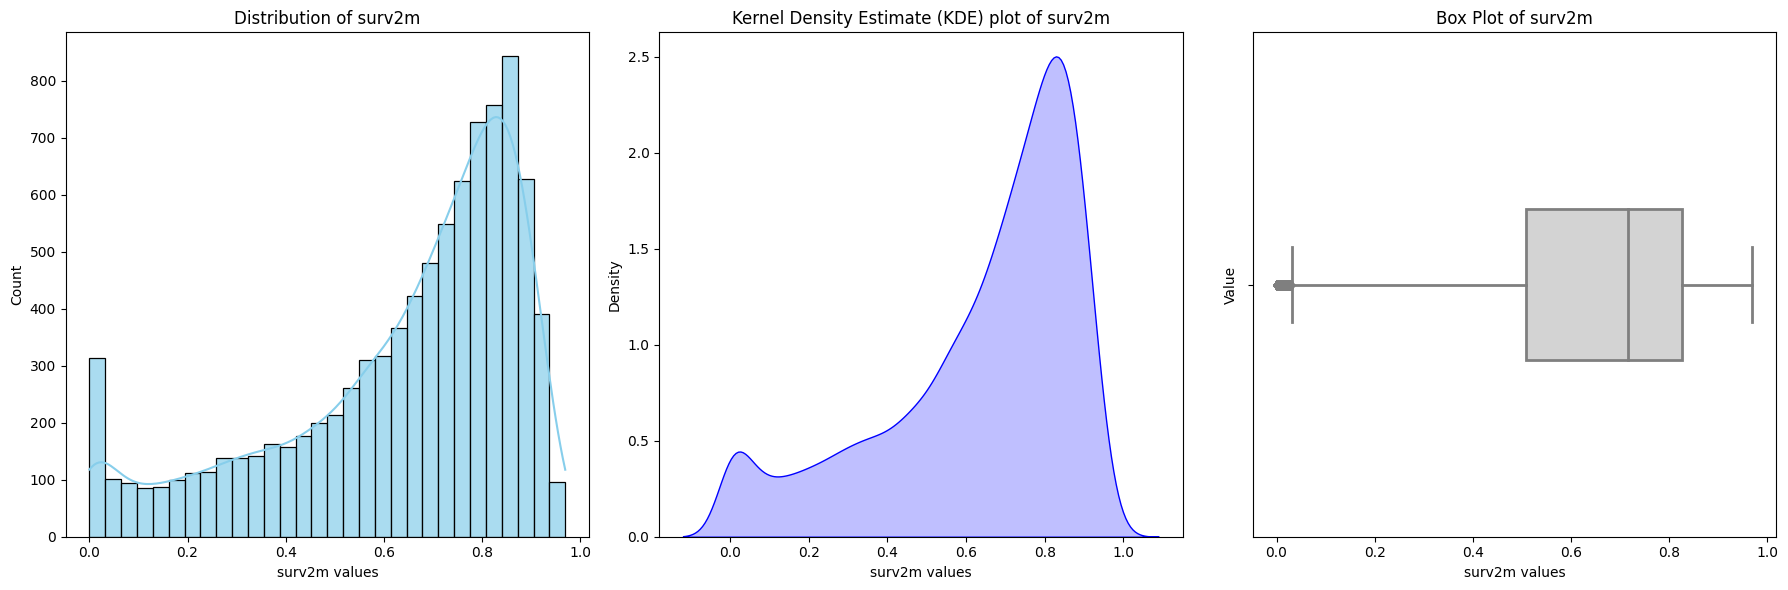

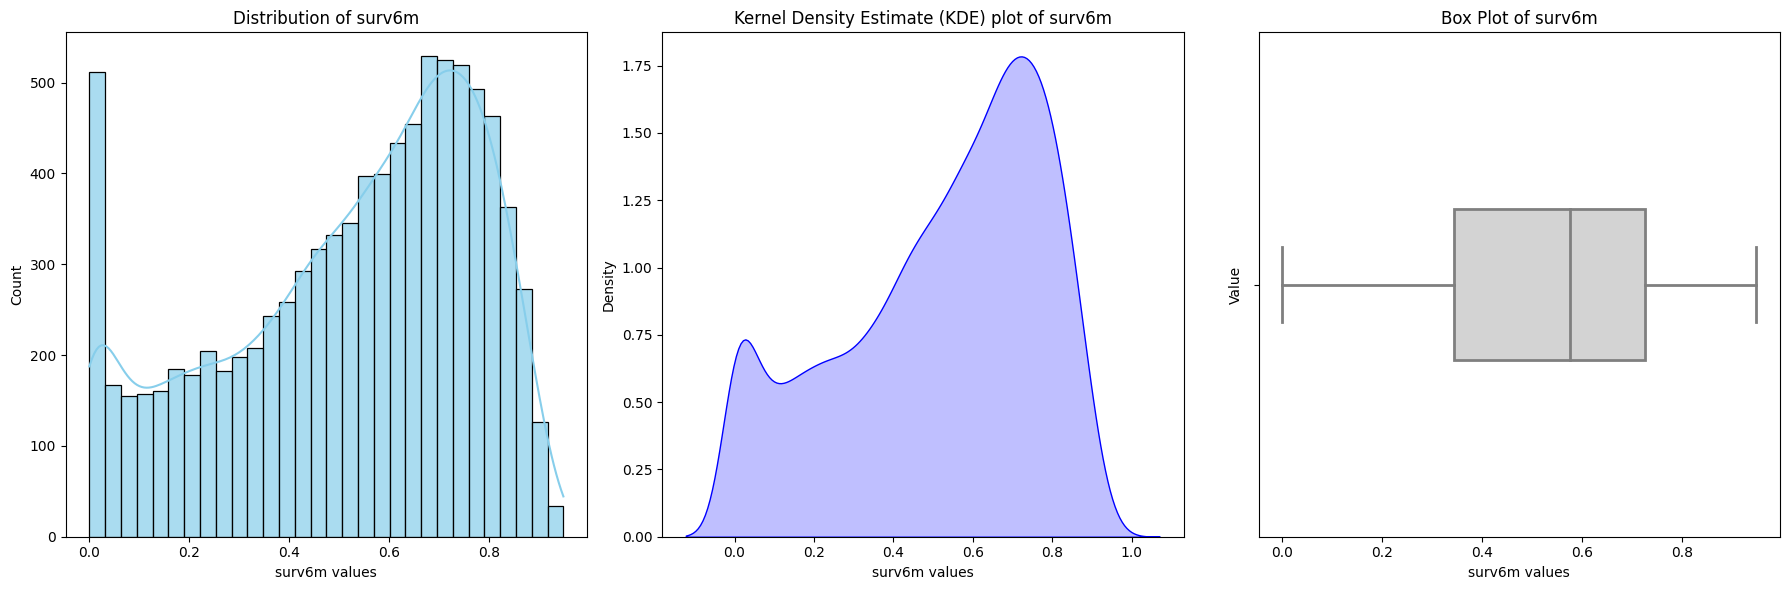

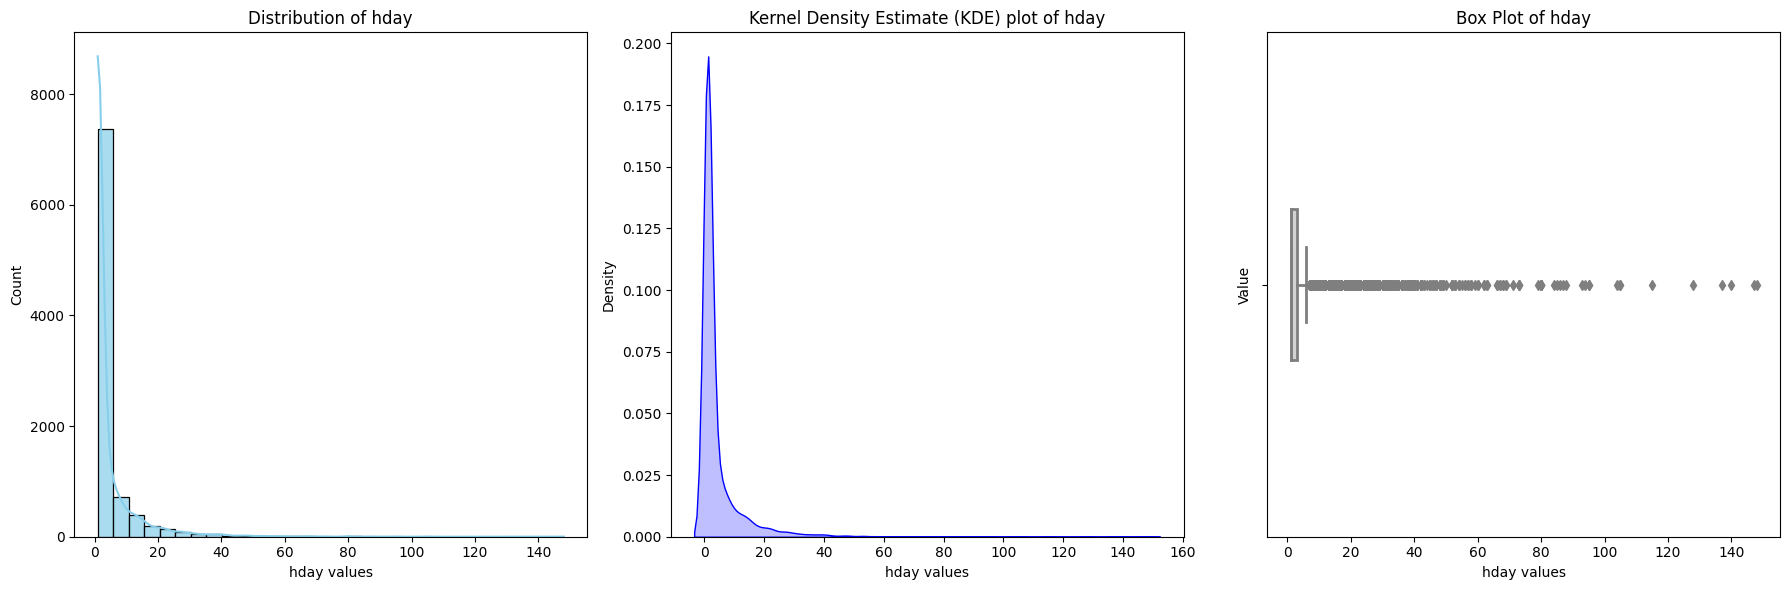

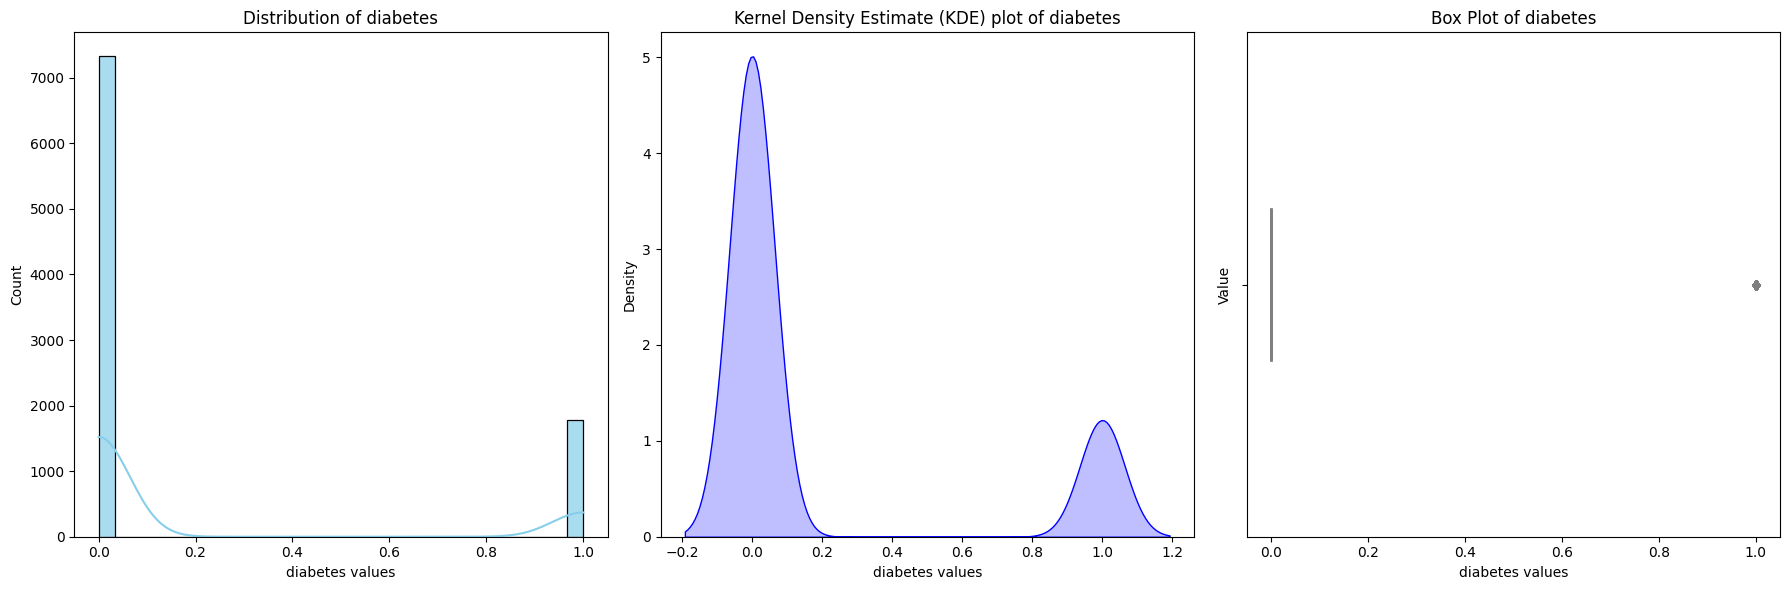

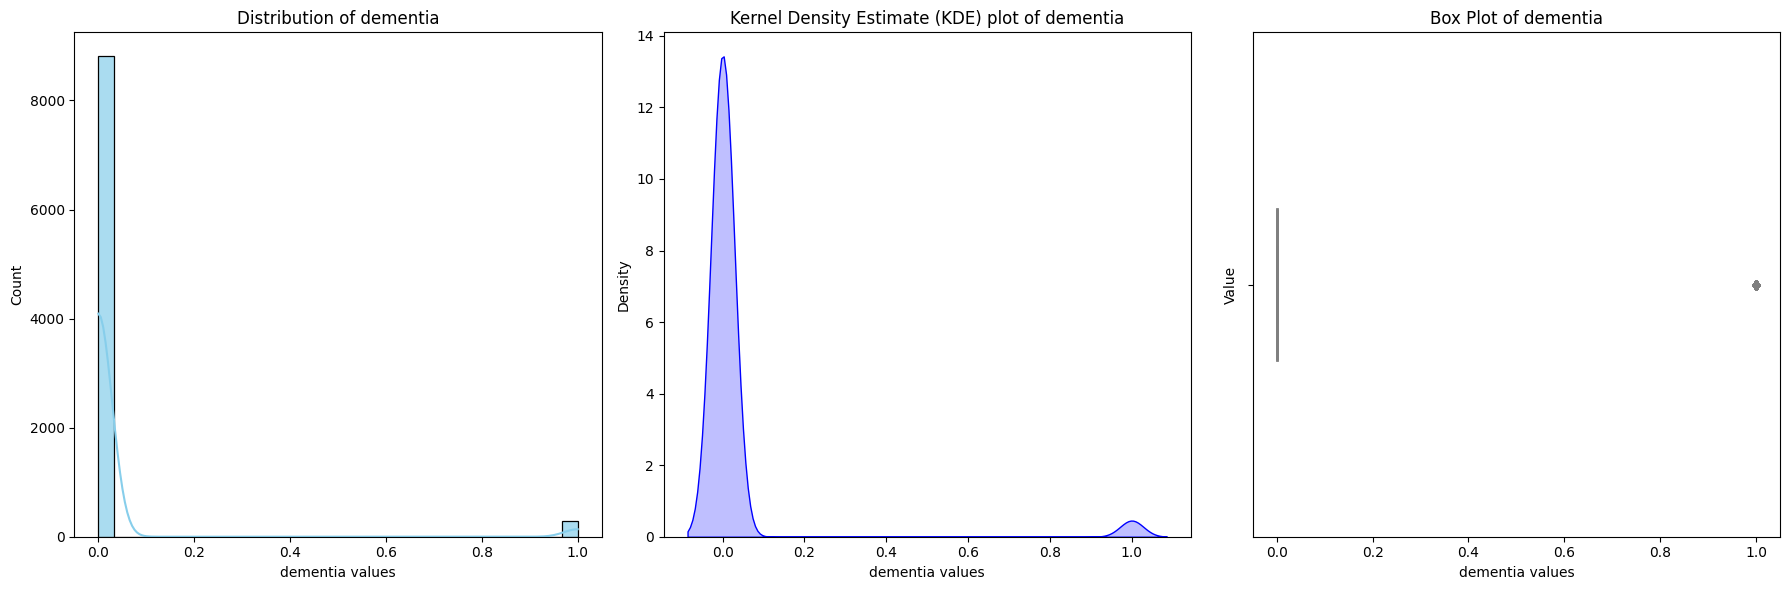

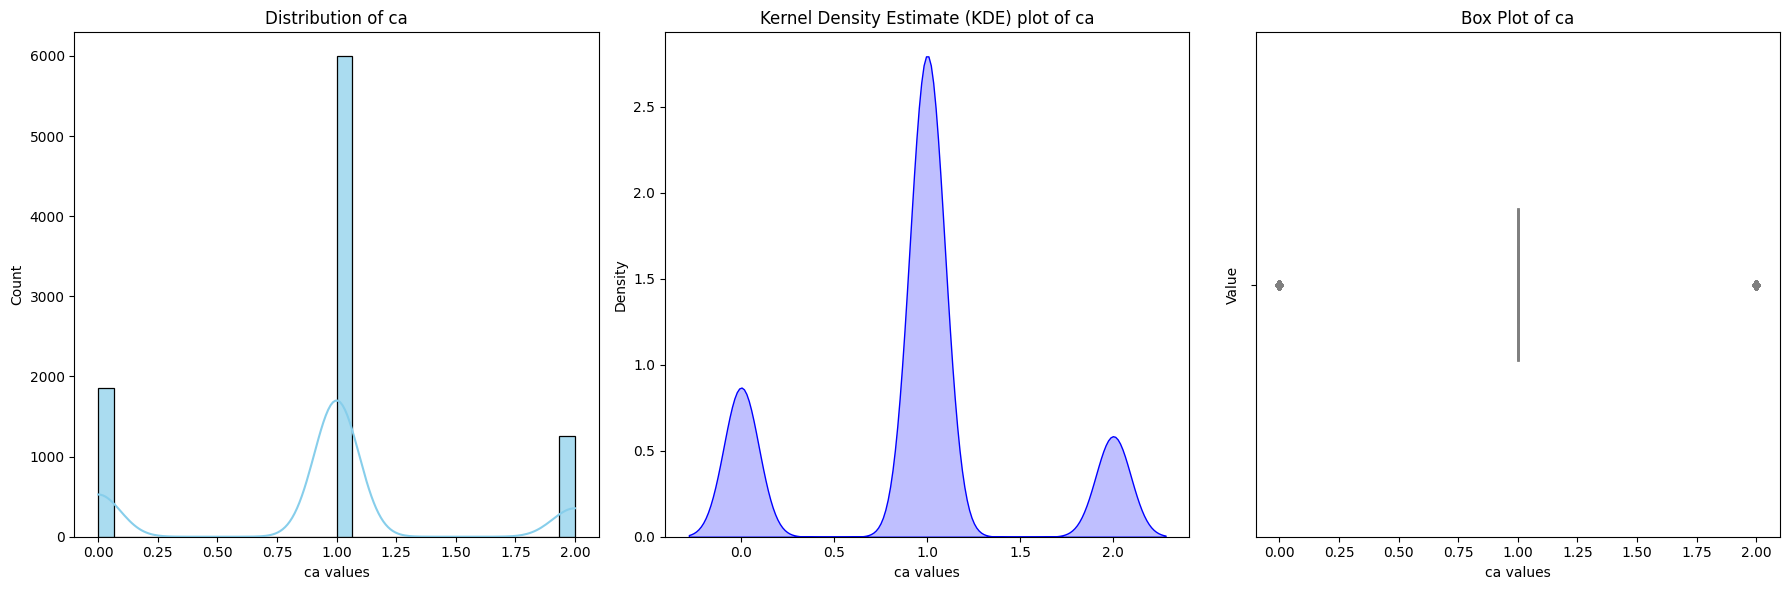

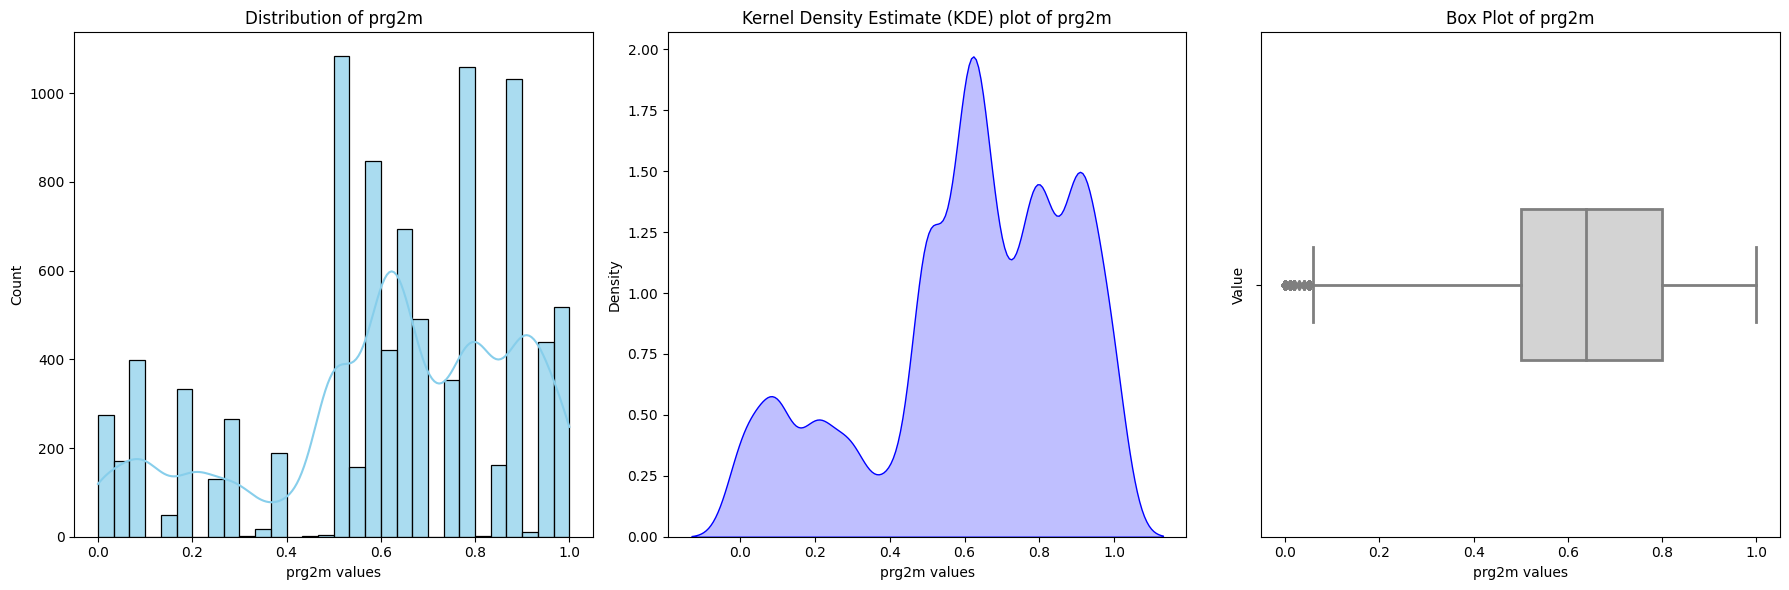

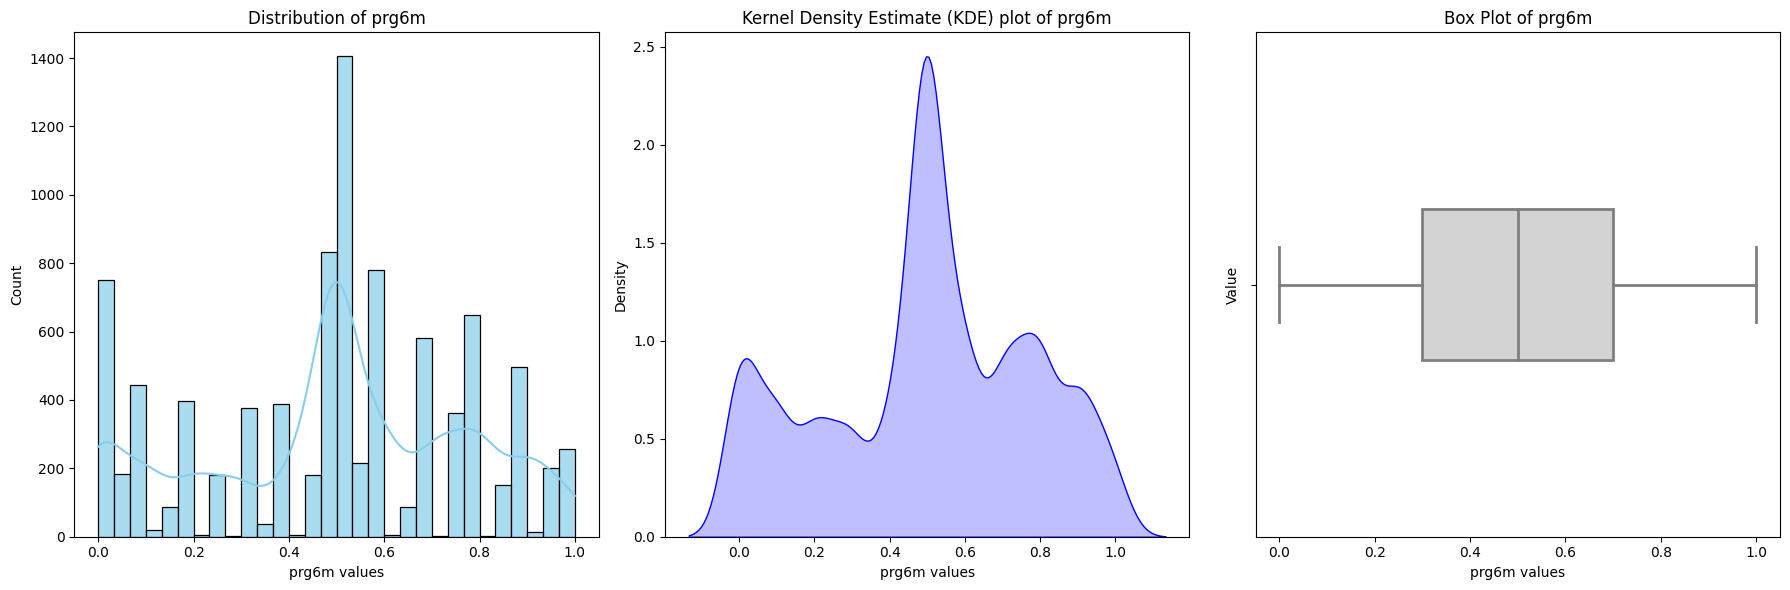

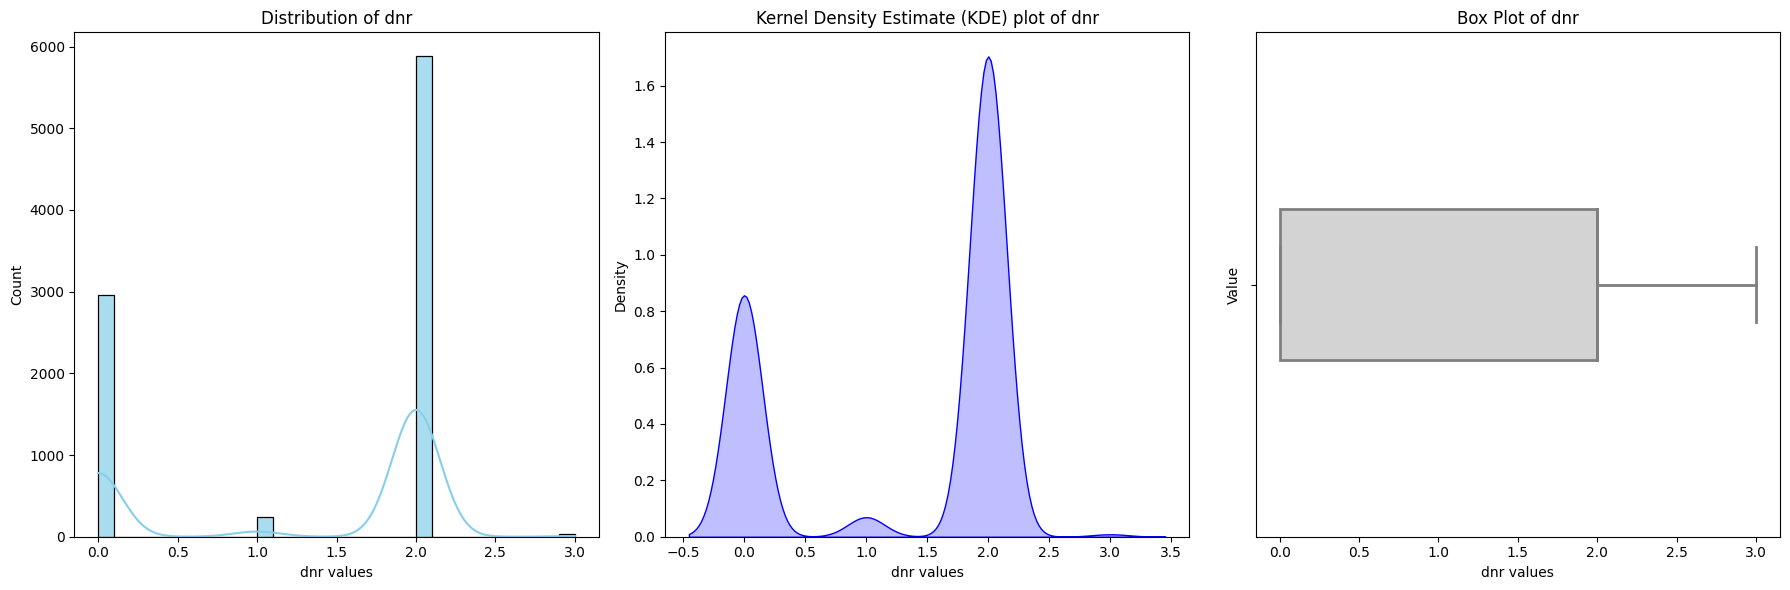

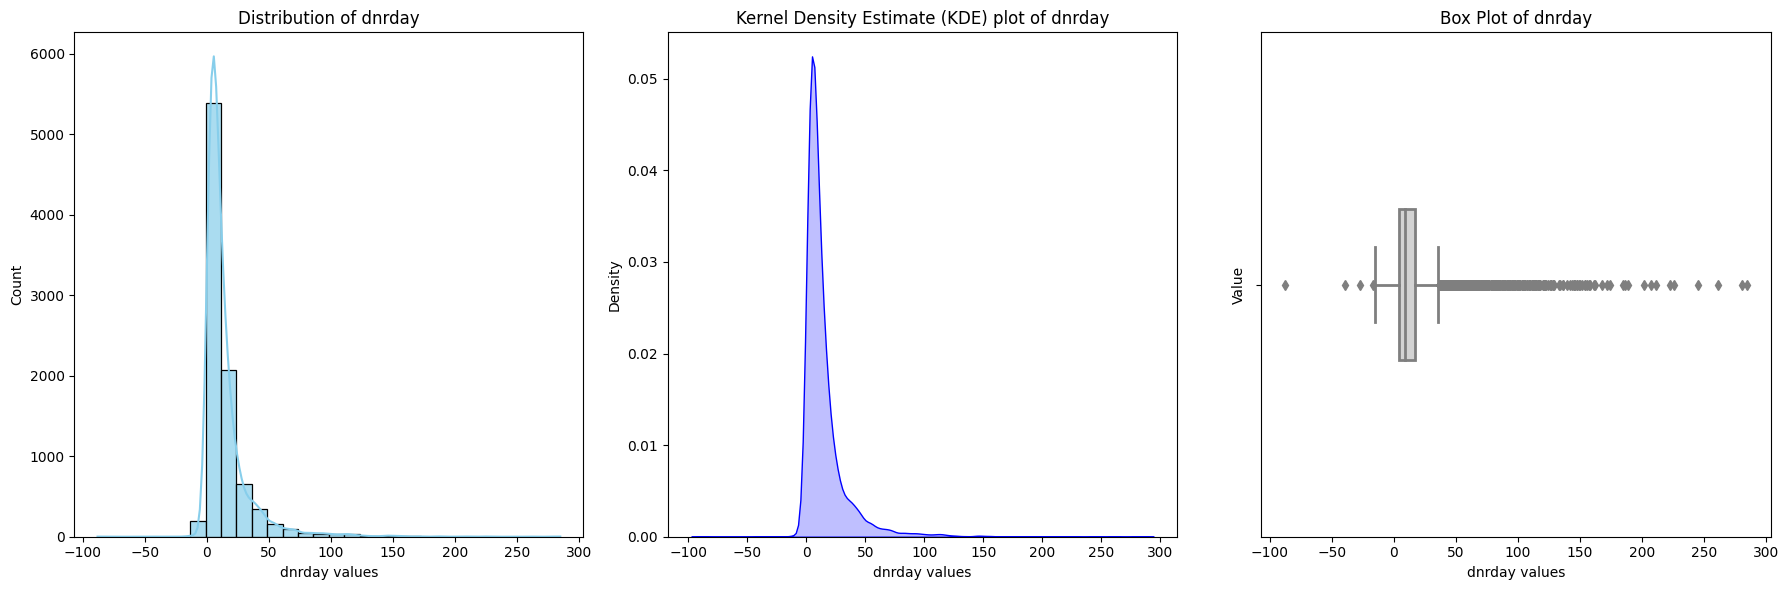

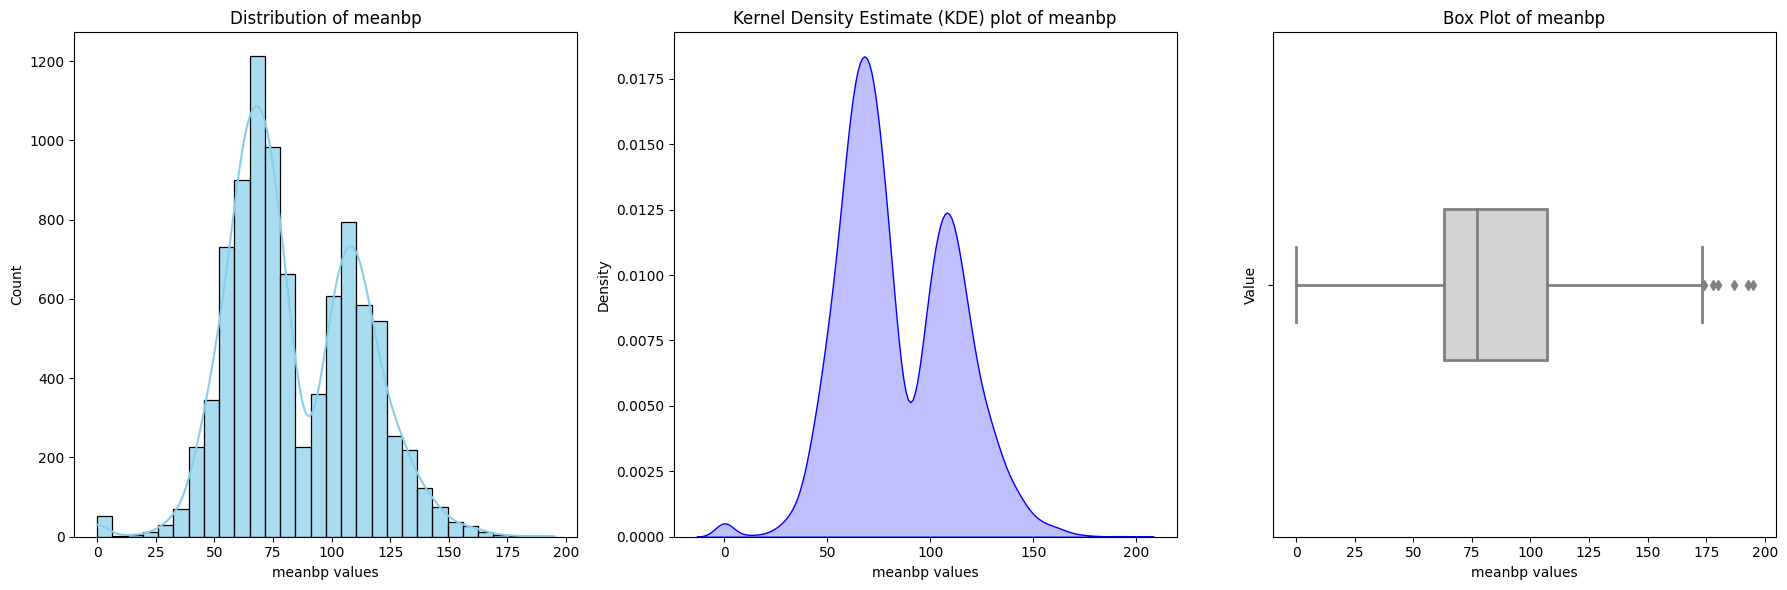

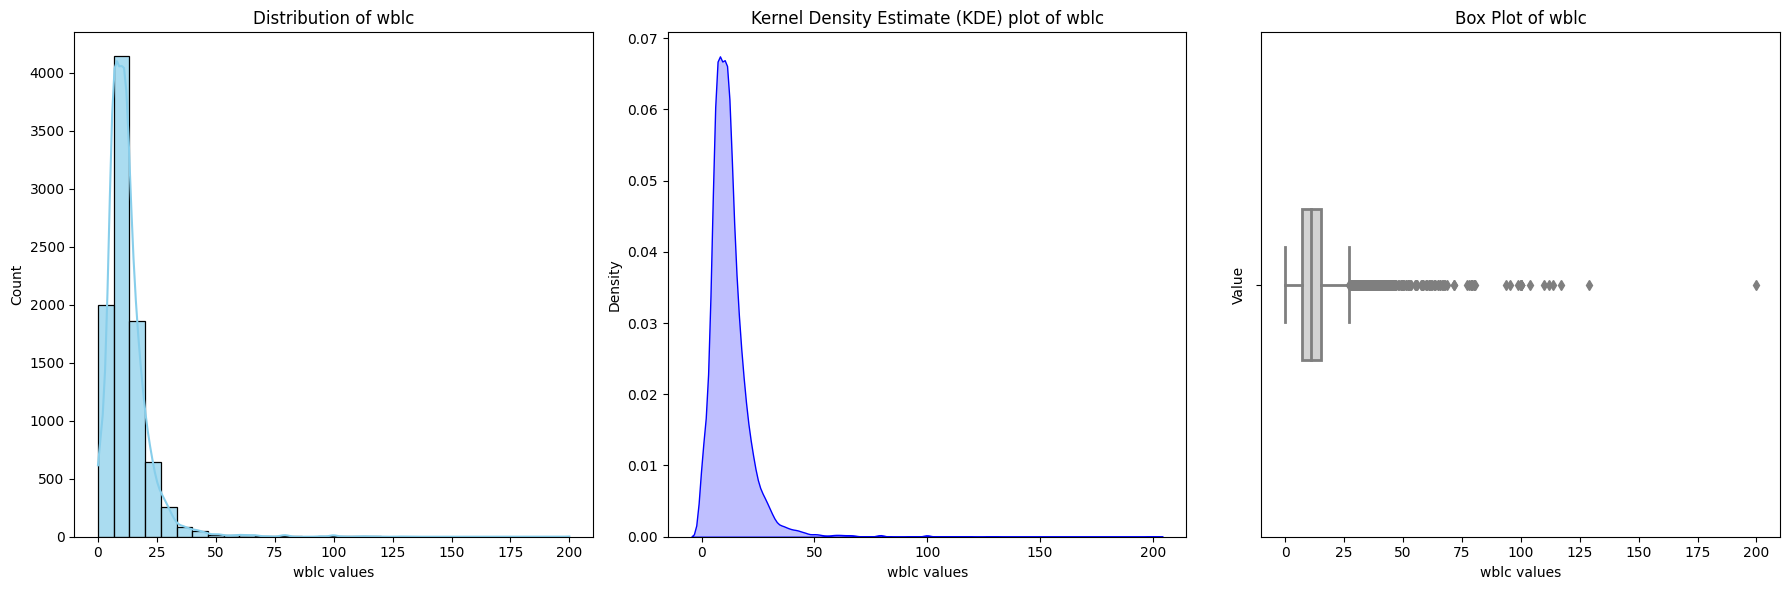

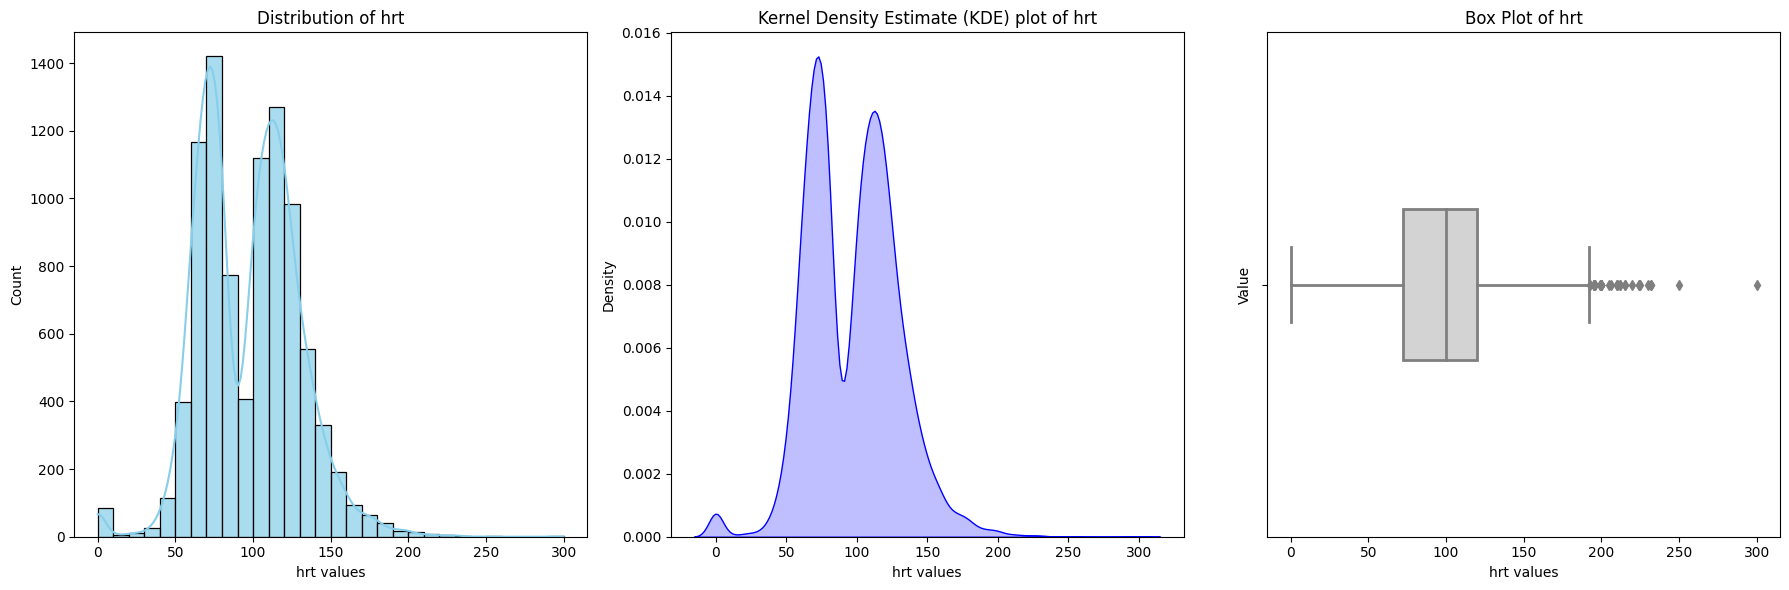

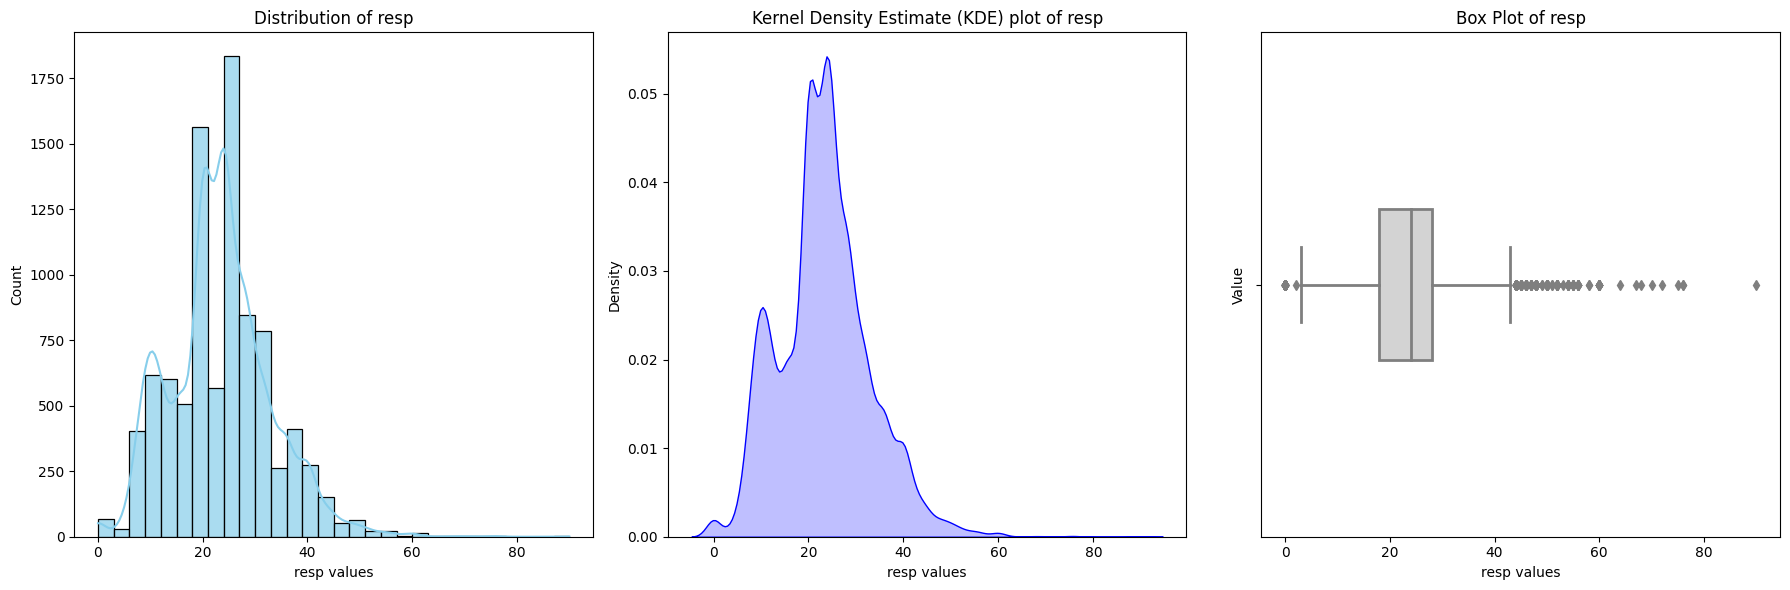

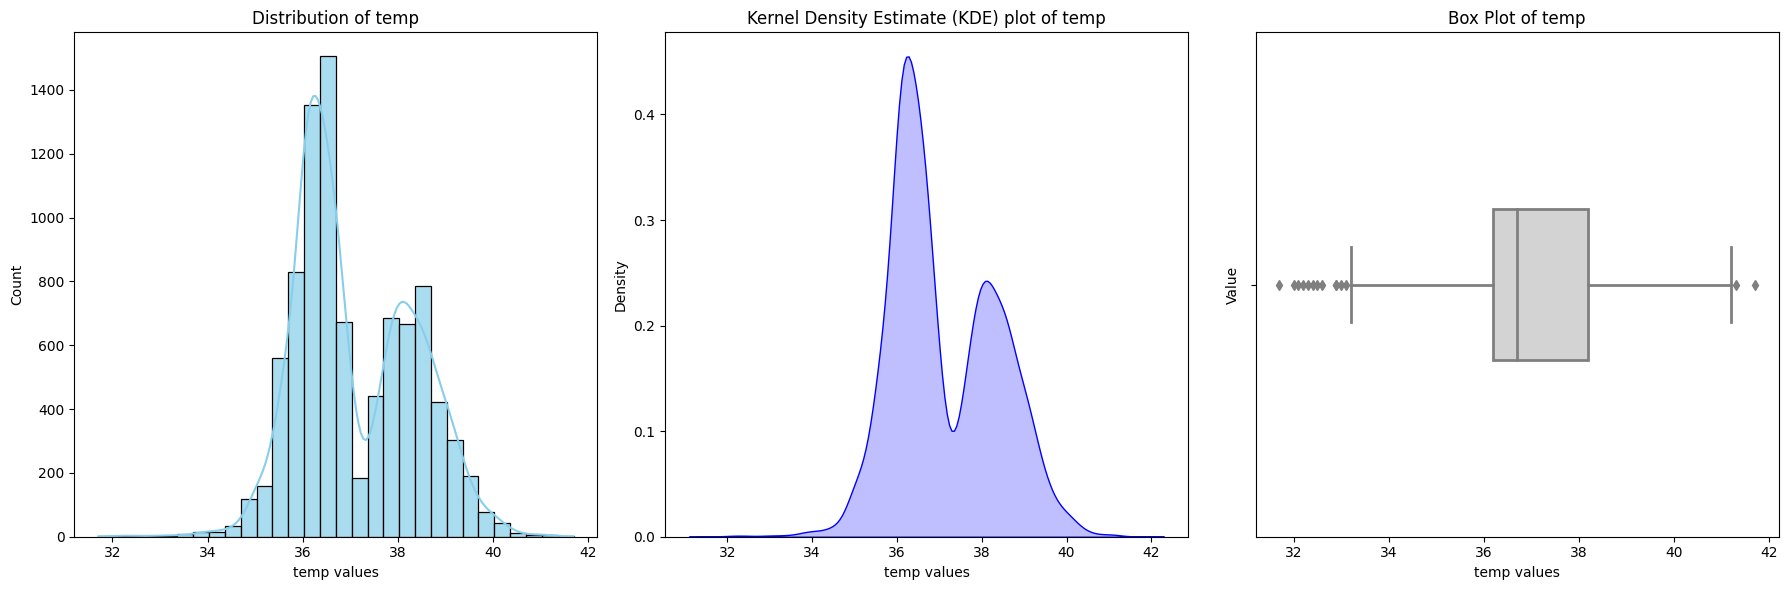

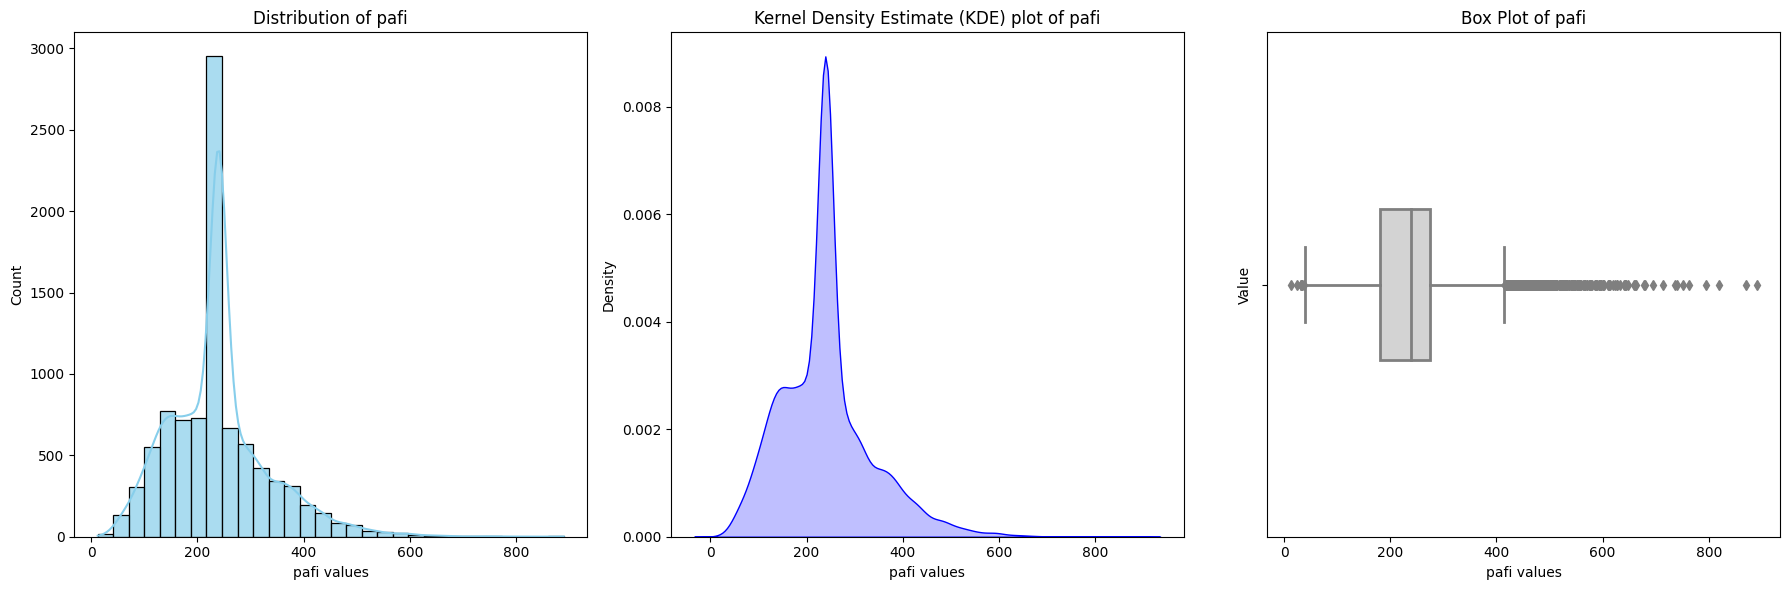

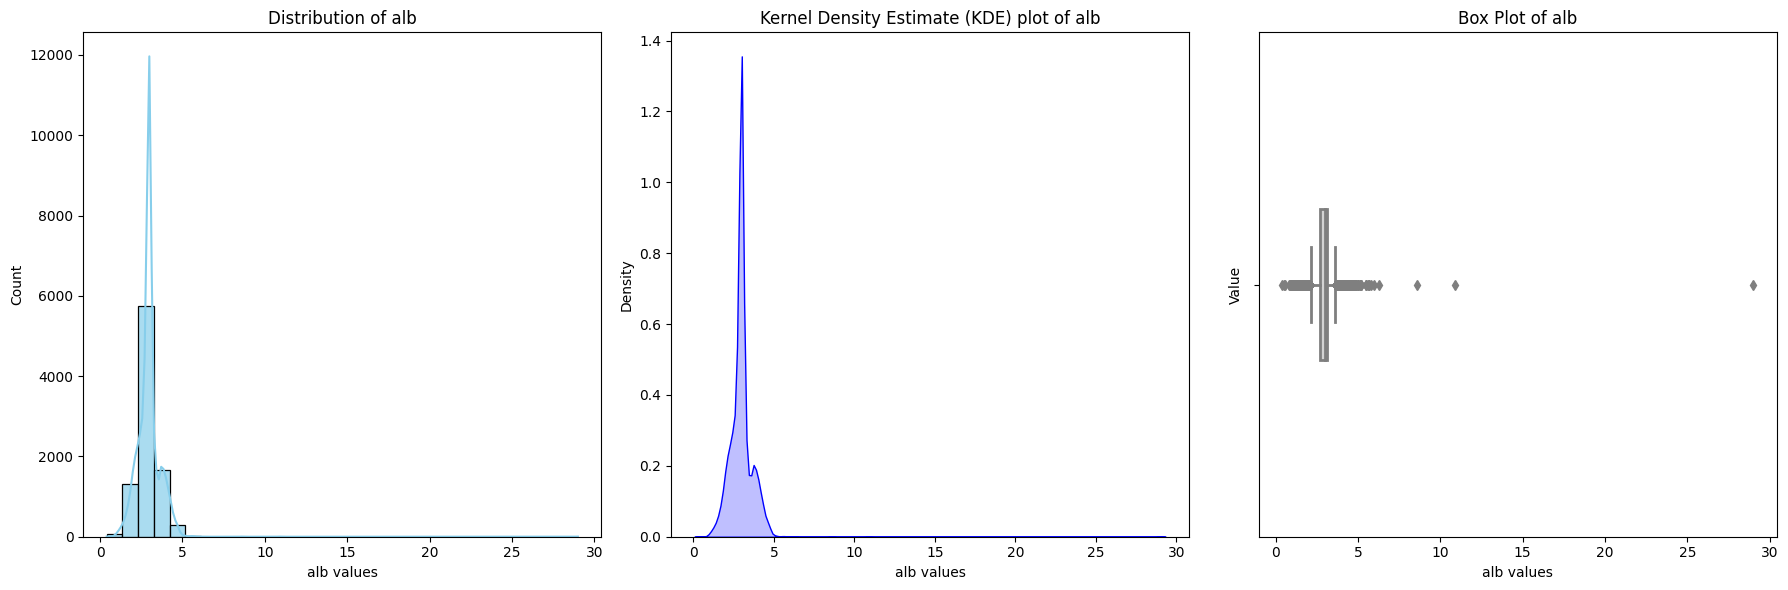

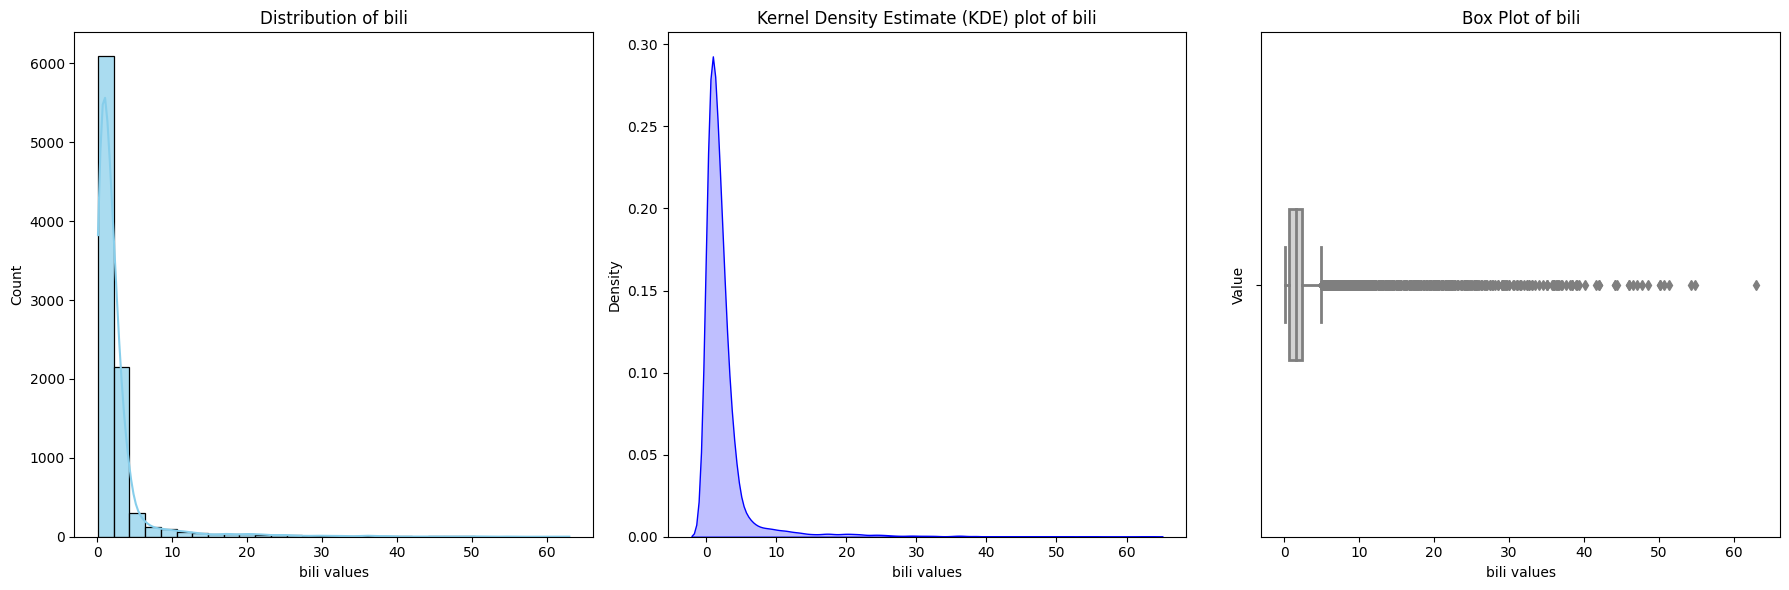

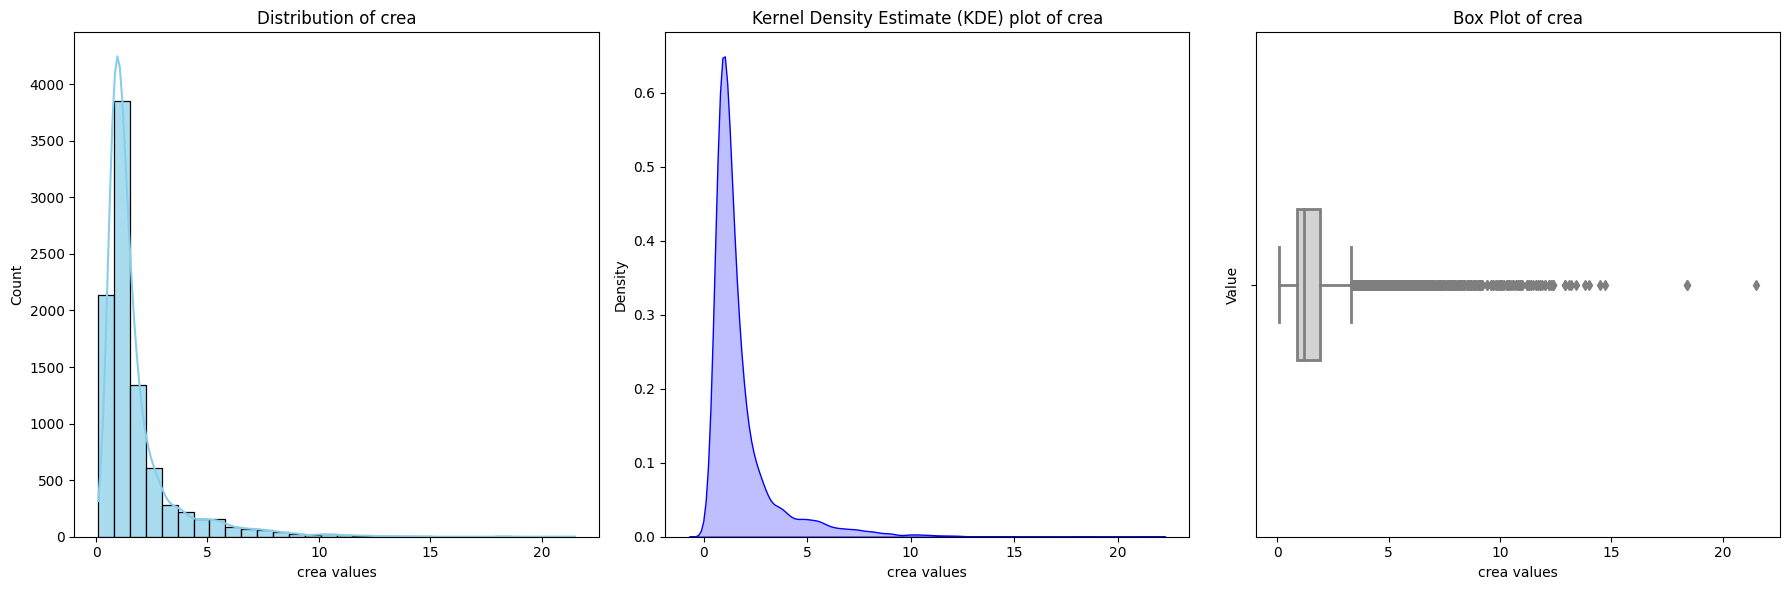

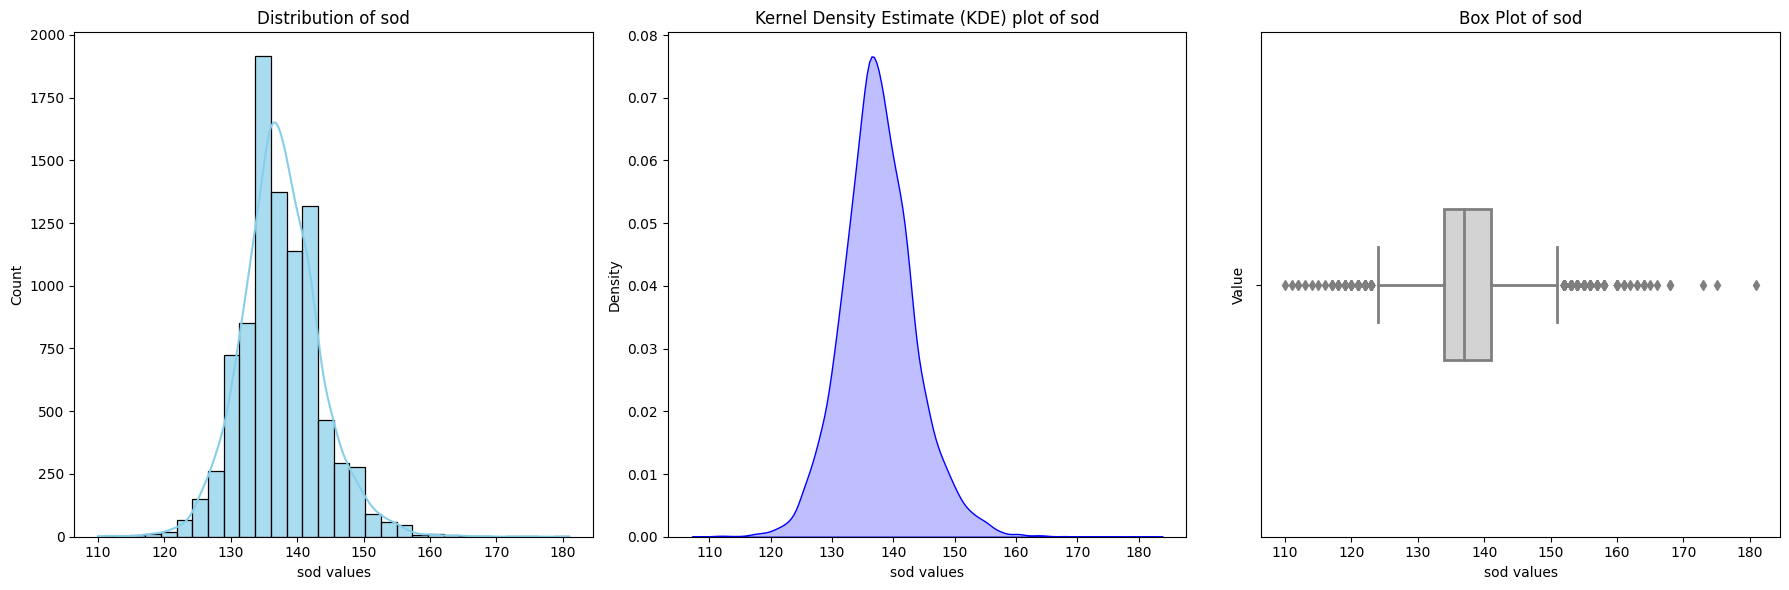

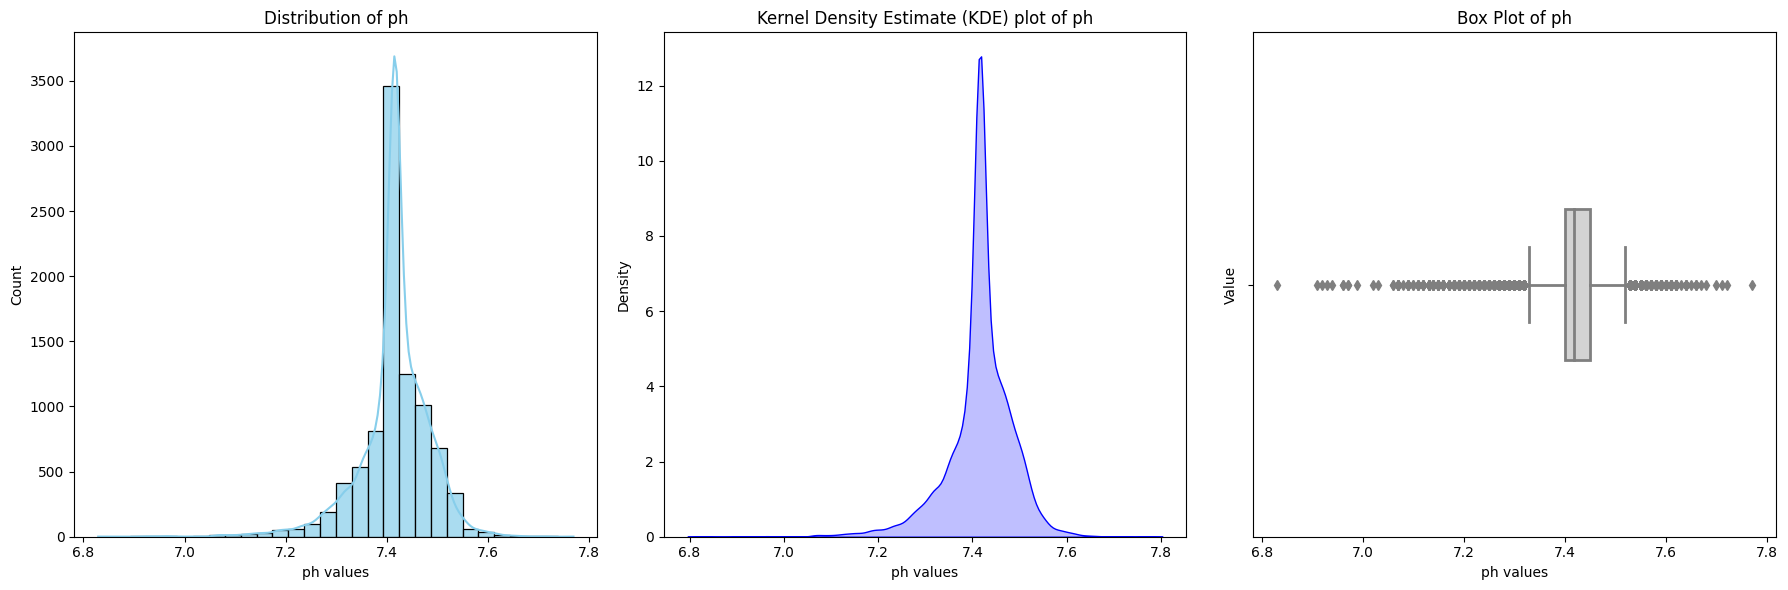

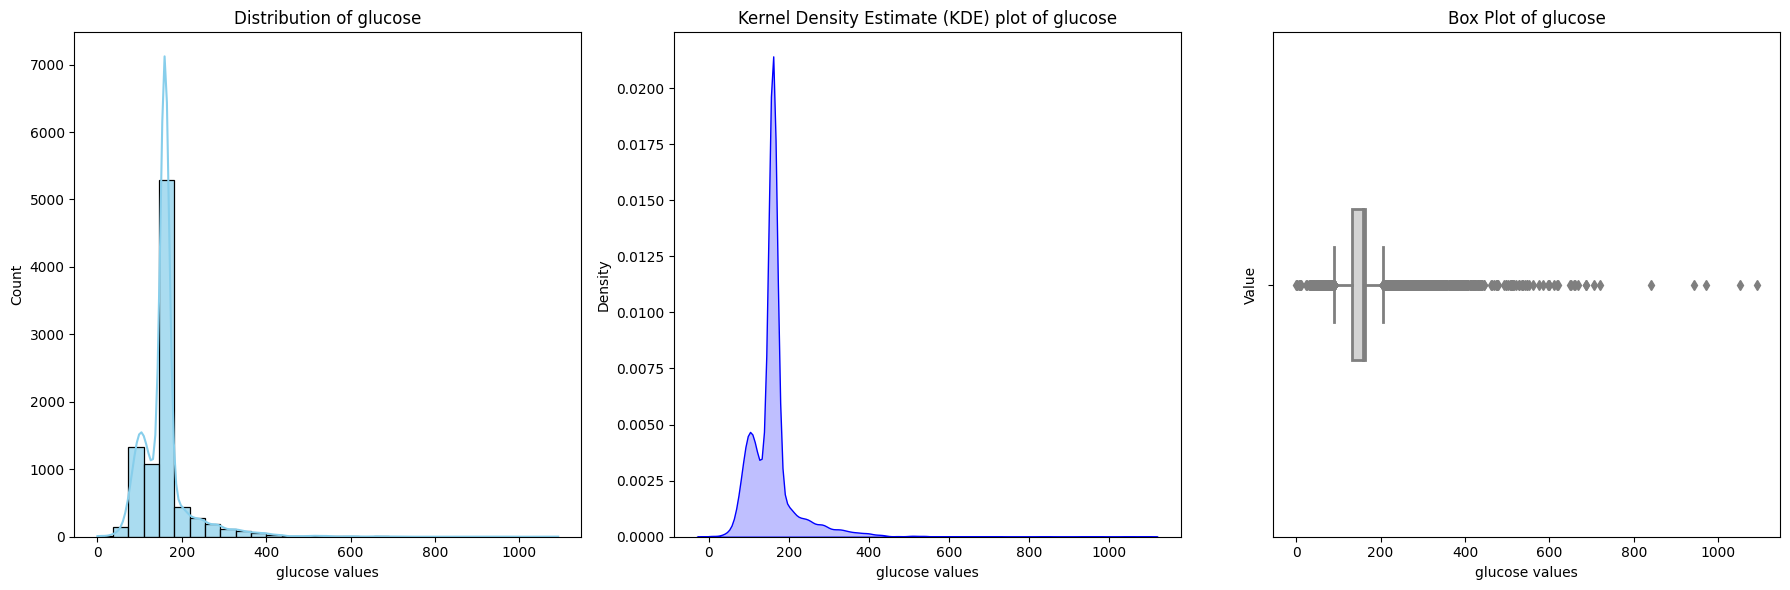

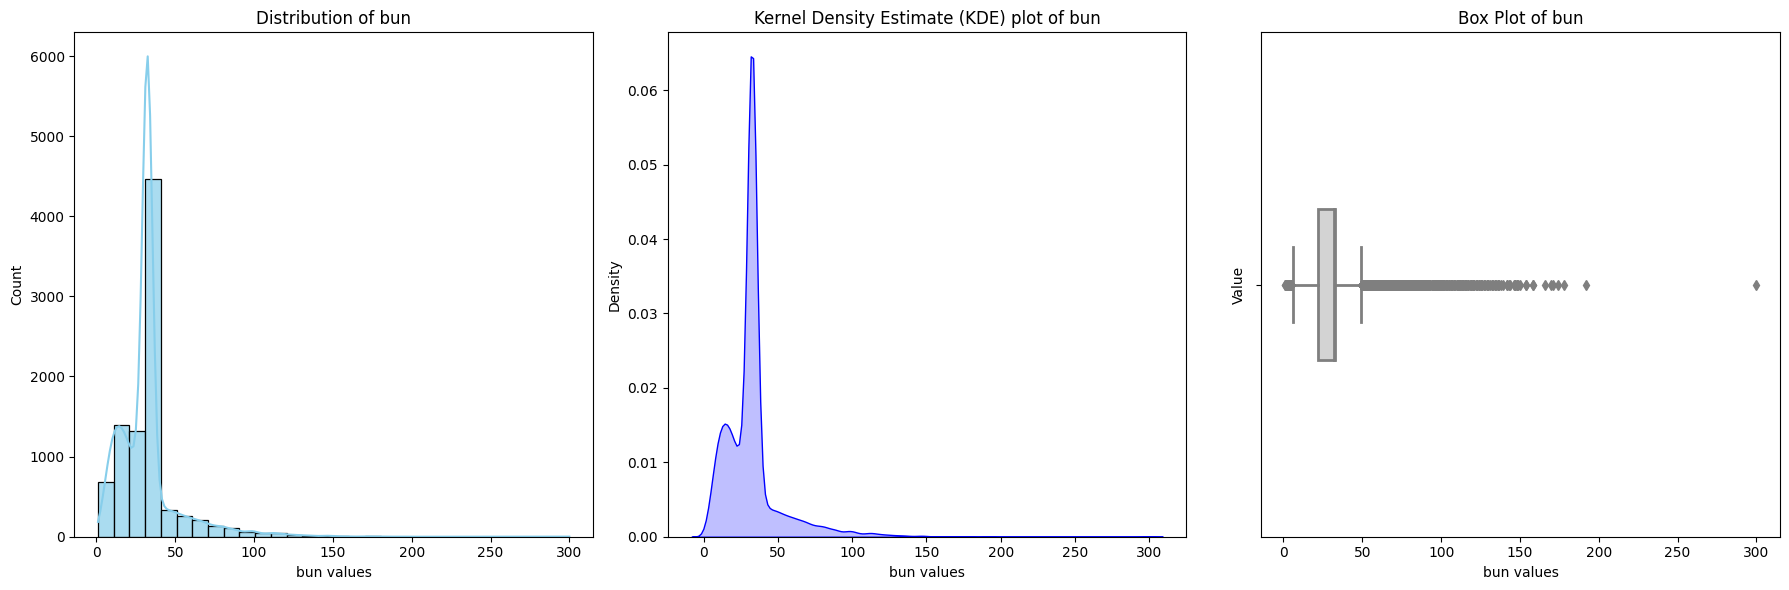

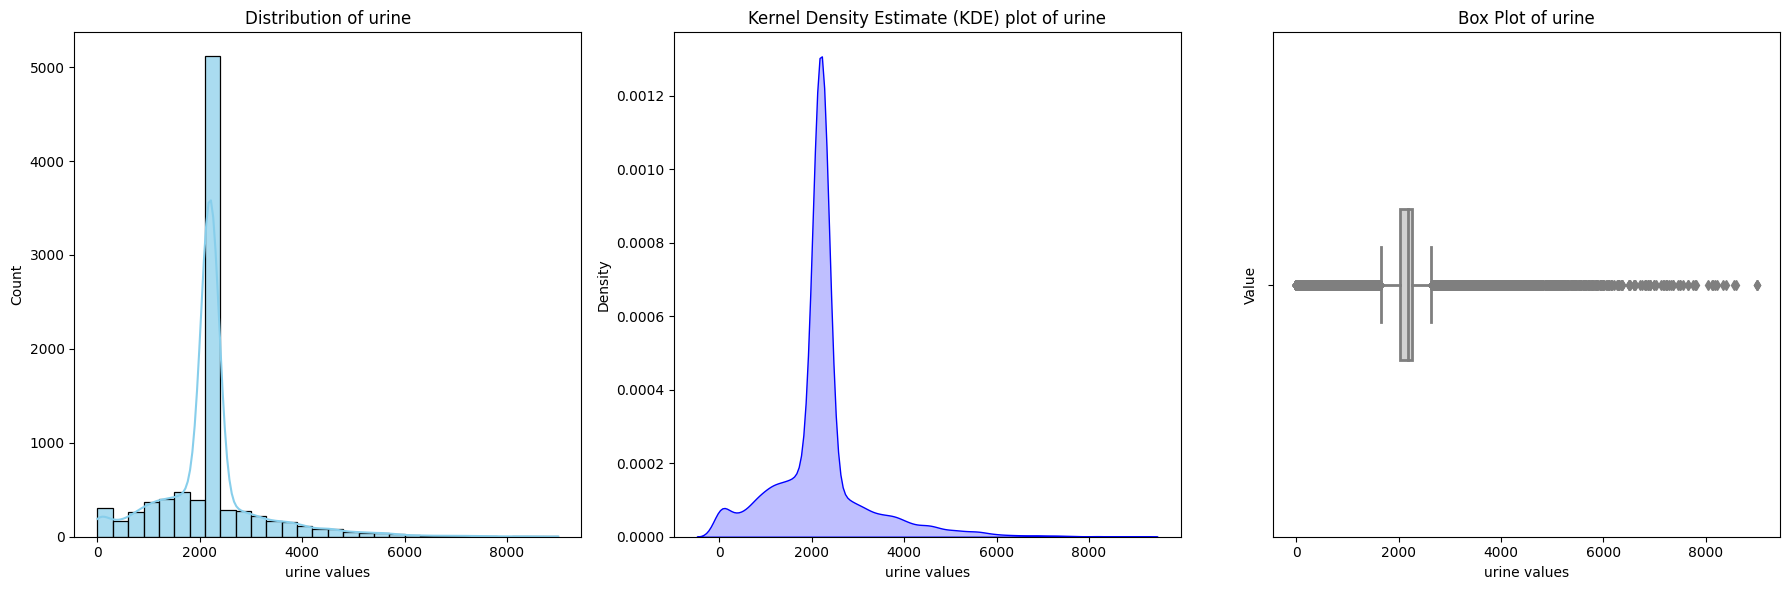

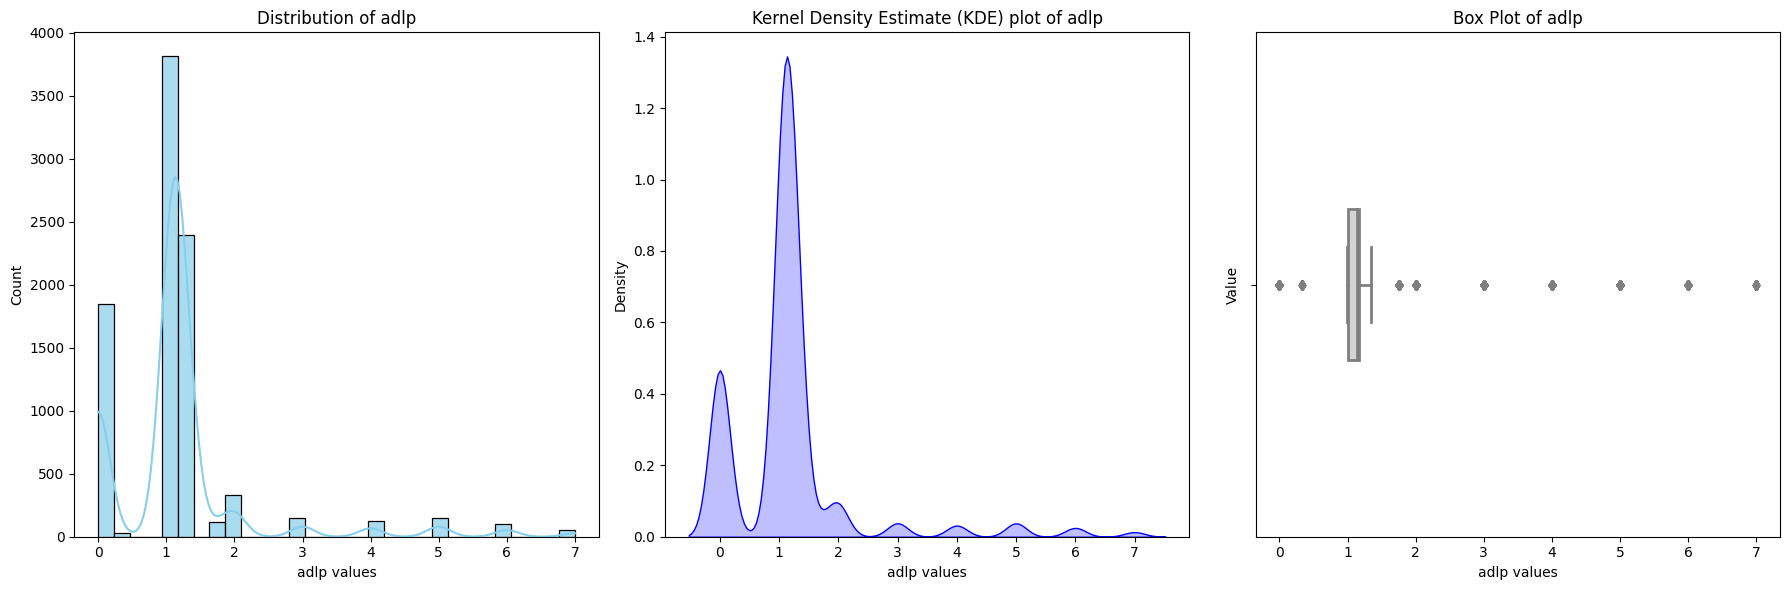

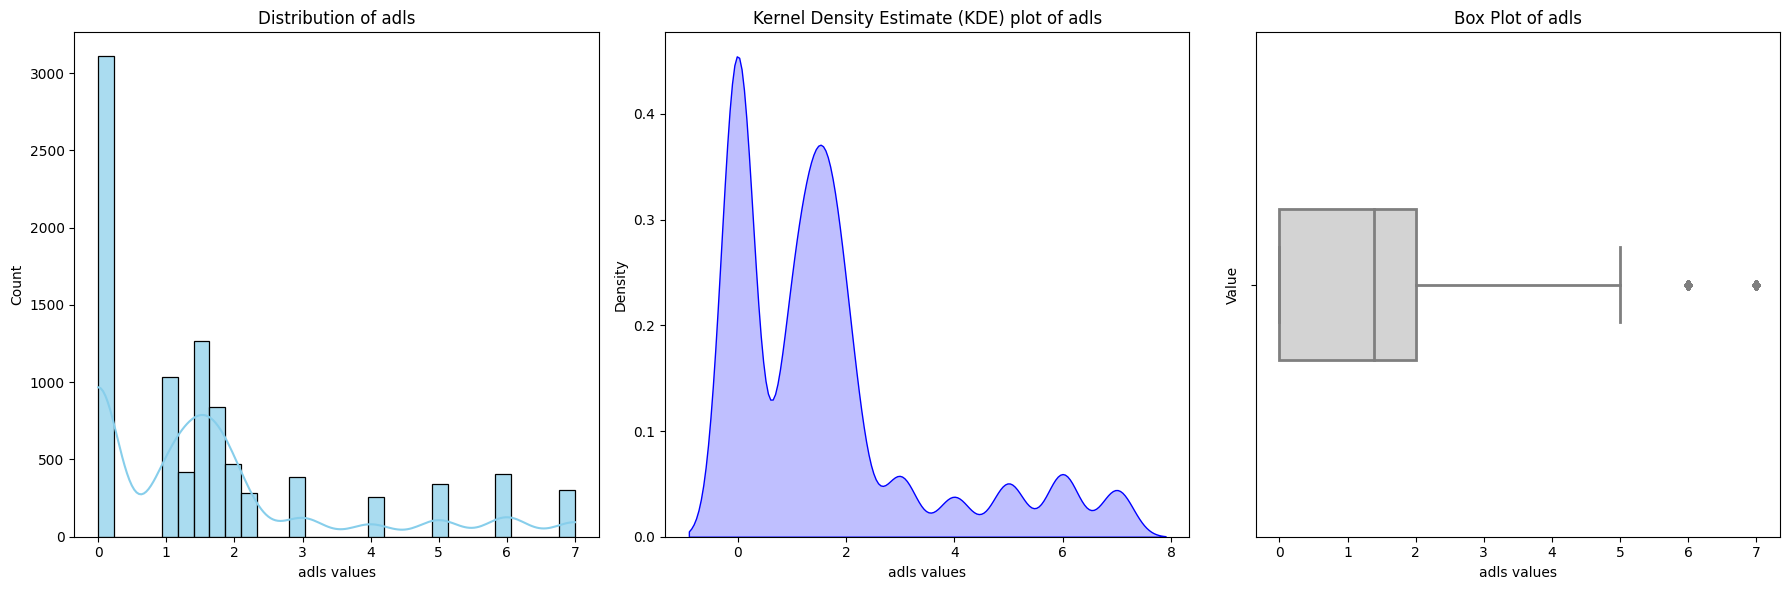

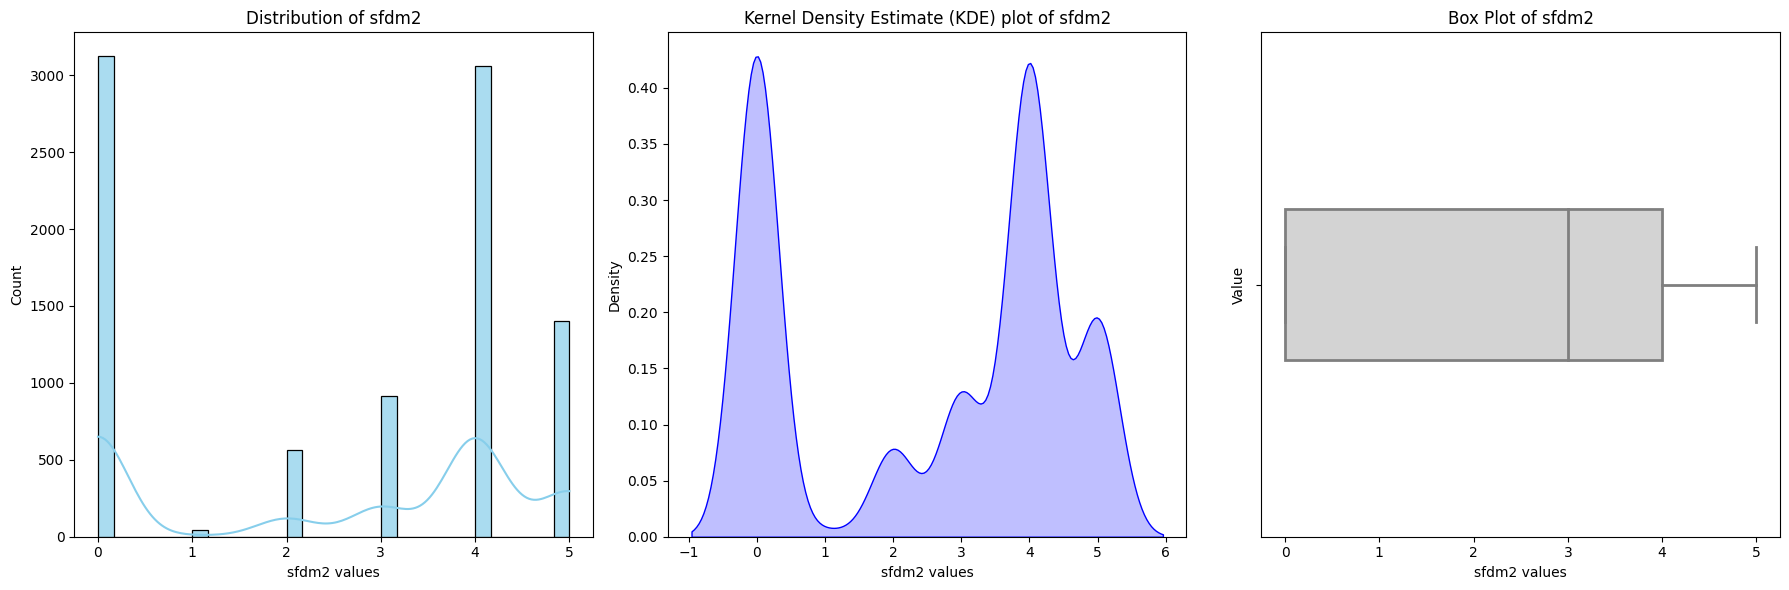

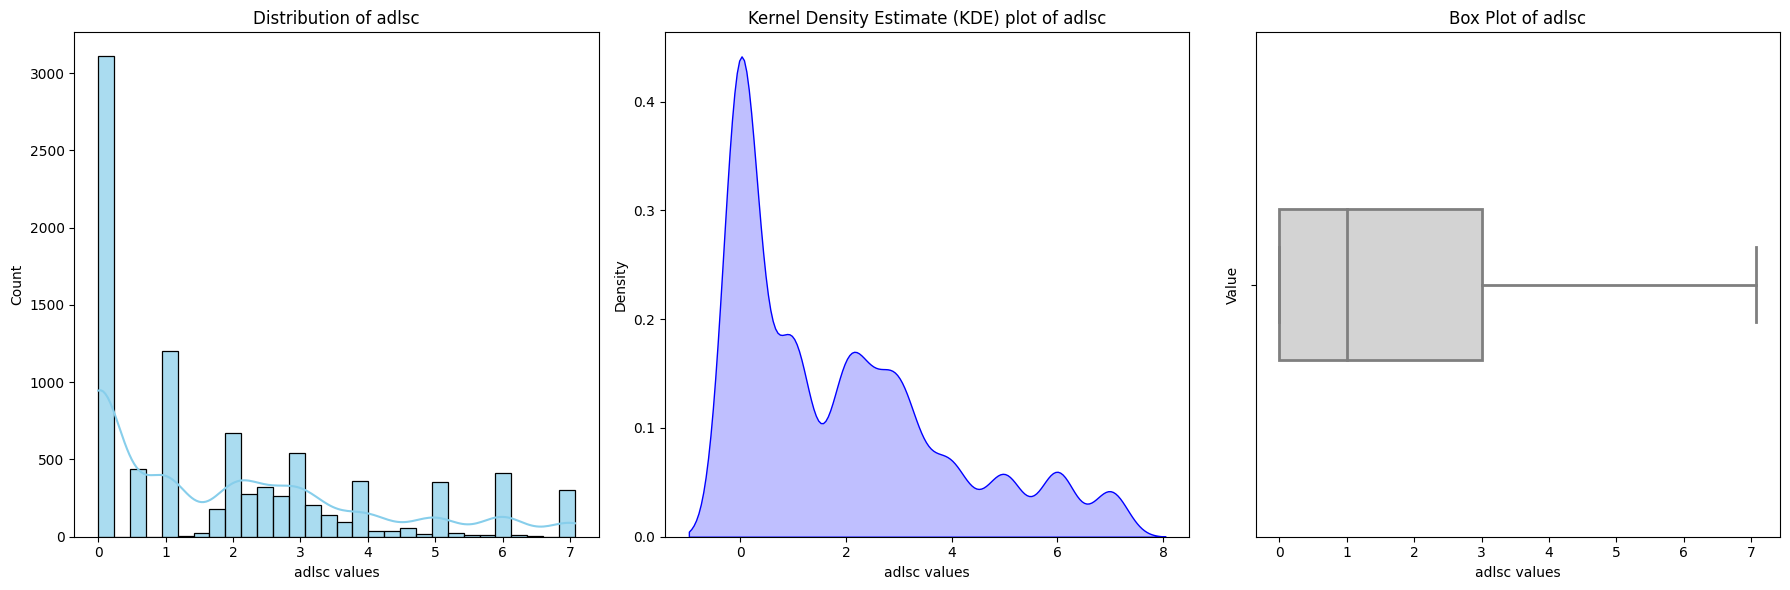

In [31]:
for col in data.columns:
  plotGraph(data[col])

#### Let's watch the relation between the different features of the dataset

##### Reading the correlation between the features

In [32]:
correlation = data.corr()
correlation


age     death       sex  hospdead      slos    d.time  \
age       1.000000  0.179230 -0.043074  0.039354 -0.085518 -0.134531   
death     0.179230  1.000000  0.032113  0.404793 -0.083098 -0.710489   
sex      -0.043074  0.032113  1.000000 -0.011819 -0.018103 -0.018382   
hospdead  0.039354  0.404793 -0.011819  1.000000 -0.010579 -0.486616   
slos     -0.085518 -0.083098 -0.018103 -0.010579  1.000000  0.096903   
d.time   -0.134531 -0.710489 -0.018382 -0.486616  0.096903  1.000000   
dzgroup  -0.036090  0.265955  0.006004  0.055673 -0.193534 -0.238786   
dzclass   0.080067  0.154561  0.006974 -0.077561 -0.221655 -0.113251   
num.co    0.127986  0.068634  0.045327 -0.077746 -0.110978 -0.045936   
edu      -0.147947 -0.005993 -0.002239  0.013440  0.030471 -0.002510   
income    0.071193  0.035026 -0.056570  0.052680 -0.003911 -0.021882   
scoma     0.006557  0.135980 -0.040459  0.379517  0.037514 -0.203649   
charges  -0.169430 -0.015126 -0.015542  0.184722  0.624065 -0.035025   
totcst   -0.164037 -0.025536 -0.005014  0.179138  0.698779 -0.008716   
totmcst  -0.172387 -0.029460 -0.015967  0.130777  0.547222 -0.024298   
avtisst  -0.134125  0.116560 -0.002236  0.551204  0.293166 -0.225087   
race      0.171956  0.029714  0.048521 -0.019703 -0.006614 -0.014960   
sps      -0.115444  0.156338  0.008246  0.462494  0.113170 -0.231471   
aps      -0.032576  0.156855  0.006333  0.475765  0.150853 -0.219620   
surv2m   -0.158056 -0.325042  0.020842 -0.558025 -0.047853  0.392705   
surv6m   -0.197112 -0.378241  0.010629 -0.498010 -0.016804  0.429056   
hday     -0.071923  0.063845 -0.015430  0.213804  0.204155 -0.089718   
diabetes  0.095958  0.011940 -0.044012 -0.013186  0.006075 -0.008120   
dementia  0.195303  0.044391 -0.030727  0.025831 -0.010820 -0.054488   
ca        0.044908 -0.119434  0.003853  0.129532  0.116551  0.081518   
prg2m    -0.092124 -0.280420  0.019559 -0.452260 -0.031346  0.348763   
prg6m    -0.143211 -0.351192  0.004111 -0.386043  0.020736  0.386291   
dnr      -0.190339 -0.374665  0.043848 -0.570447 -0.025574  0.430100   
dnrday   -0.157095 -0.146654 -0.001262 -0.055729  0.881544  0.158066   
meanbp   -0.040134 -0.031751 -0.008201 -0.087593  0.006807  0.057192   
wblc      0.004469 -0.004715 -0.016122  0.069082  0.066222 -0.038684   
hrt      -0.126309 -0.003836 -0.013200  0.095478  0.091680 -0.039518   
resp     -0.021641  0.006327 -0.004776  0.020779 -0.000187 -0.002239   
temp     -0.085967 -0.029455 -0.005782  0.069968  0.102535  0.008443   
pafi      0.018721  0.002758 -0.037926 -0.093075 -0.054283  0.050958   
alb       0.104148  0.018304 -0.016110 -0.112488 -0.086275  0.047989   
bili     -0.153782  0.018188  0.021418  0.141043  0.025728 -0.058351   
crea      0.001964  0.026648  0.026471  0.098475  0.044786 -0.046097   
sod       0.013981 -0.018411 -0.014642  0.029904  0.033877  0.000316   
ph       -0.022118 -0.007523  0.020710 -0.034676  0.032050  0.020144   
glucose  -0.012684  0.001169 -0.005351  0.008651  0.005803  0.000272   
bun       0.030785  0.017073 -0.002150  0.026210  0.006617 -0.011135   
urine    -0.060623 -0.007576  0.021651 -0.013334  0.016960  0.012828   
adlp      0.070638  0.078923 -0.072952  0.037195  0.034484 -0.061972   
adls      0.115042  0.127293 -0.083472  0.075513  0.022454 -0.106196   
sfdm2    -0.090613 -0.465243  0.013011 -0.716833  0.065740  0.563288   
adlsc     0.115379  0.154760 -0.078473  0.126350  0.019143 -0.136521   

           dzgroup   dzclass    num.co       edu  ...      crea       sod  \
age      -0.036090  0.080067  0.127986 -0.147947  ...  0.001964  0.013981   
death     0.265955  0.154561  0.068634 -0.005993  ...  0.026648 -0.018411   
sex       0.006004  0.006974  0.045327 -0.002239  ...  0.026471 -0.014642   
hospdead  0.055673 -0.077561 -0.077746  0.013440  ...  0.098475  0.029904   
slos     -0.193534 -0.221655 -0.110978  0.030471  ...  0.044786  0.033877   
d.time   -0.238786 -0.113251 -0.045936 -0.002510  ... -0.046097  0.000316   
dzgroup   1.000000 

##### Visualizing the correlation between the features

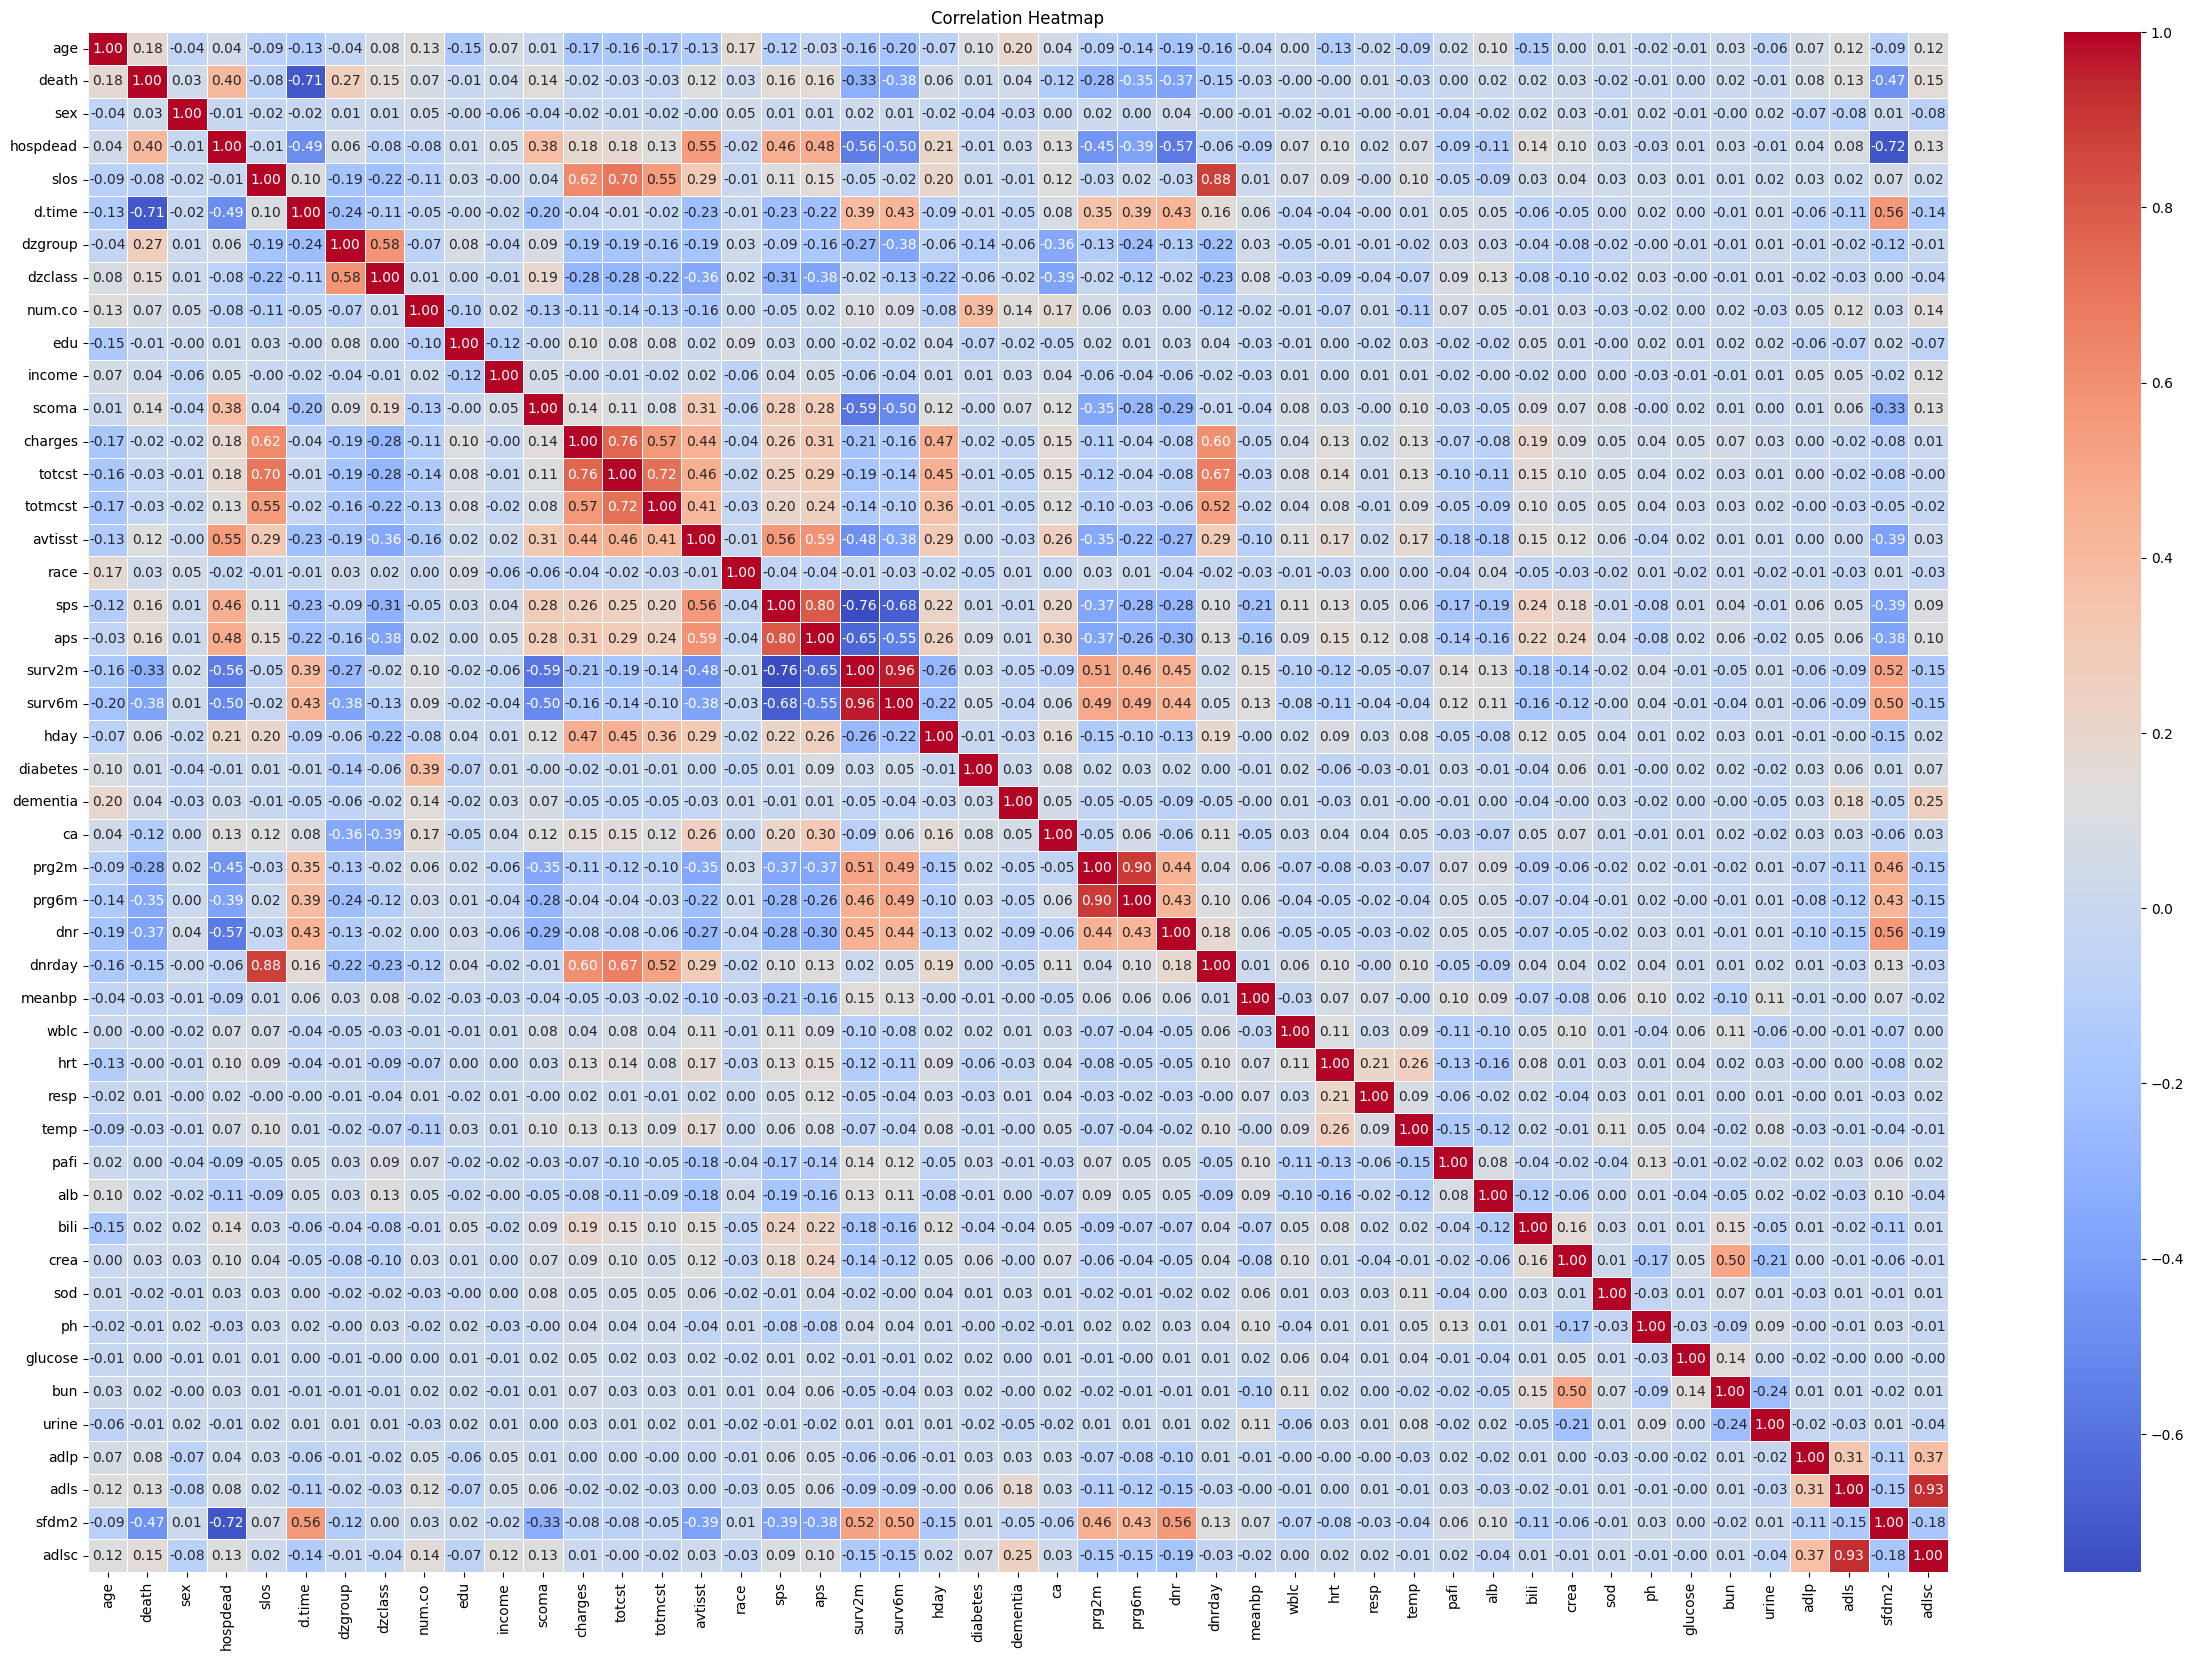

In [33]:
plt.figure(figsize=(30, 20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.savefig('correlation_heatmap.jpg', format='jpg')
plt.show()


## Model Building and Training

### Split the dataset to visualize it.

#### Categories the features of the dataset according to the requirements of the model and segregate them as follows:
- ***Patient Data***, which are directly related to the patient like `age`, `education`, `sex`, `income`, etc.
- ***Processed Data***, which are necessary for the processing of the model like `glucose level`, `temperature`, `pH`, `sodium level`, `urine test`, etc.
- ***Target Data***, which are required to predict by the model after processing the dataset.

In [34]:
patientData = ['age', 'avtisst', 'charges', 'd.time', 'edu', 'income', 'race', 'sex', 'slos', 'totcst', 'totmcst']

processedData = ['adlp', 'adls', 'adlsc', 'alb', 'bili', 'bun', 'crea', 'glucose', 'hrt', 'meanbp', 'pafi', 'ph',
                 'resp', 'sod', 'temp', 'urine', 'wblc']

targetData = ['aps', 'ca', 'death', 'dementia', 'diabetes', 'dnrday', 'dnr', 'dzclass', 'dzgroup', 'hday', 'hospdead',
              'num.co', 'prg2m', 'prg6m', 'scoma', 'sfdm2', 'sps', 'surv2m', 'surv6m']

print(len(patientData) + len(processedData) + len(targetData))


47


In [35]:
patientdf = data[patientData]
print(patientdf.shape)
patientdf.head()


(9105, 11)


age  avtisst   charges  d.time        edu  income  race  sex  slos  \
9095  18.04199    18.00   32141.0   358.0  11.666667     4.0   4.0  0.0  12.0   
1158  18.11899    51.50  262520.0     8.0  12.000000     3.0   4.0  1.0   8.0   
178   18.14600    43.25  641888.0  1899.0  12.000000     0.0   2.0  1.0  85.0   
8083  18.16299    29.00   28791.0    13.0  11.000000     3.0   4.0  1.0  13.0   
8770  18.18999    26.00   49598.0   718.0  11.000000     4.0   4.0  0.0  21.0   

             totcst     totmcst  
9095   55334.786417  40894.8229  
1158   47710.156200  49025.6875  
178   328378.500000  40894.8229  
8083   19518.812500  19102.4688  
8770   32209.937500  39172.5000

In [36]:
processdf = data[processedData]
print(processdf.shape)
processdf.head()


(9105, 17)


adlp      adls     adlsc       alb      bili        bun       crea  \
9095  0.333333  1.384615  2.147461  2.904148  3.877954  18.000000   0.899902   
1158  0.333333  0.000000  0.000000  1.699951  3.877954  27.000000   0.899902   
178   0.333333  0.000000  0.000000  1.899902  0.299988  28.611111  10.699219   
8083  0.333333  0.000000  0.000000  2.899902  1.099854  28.611111   0.899902   
8770  0.333333  0.000000  0.000000  2.904148  0.299988  16.000000   0.799927   

         glucose    hrt  meanbp        pafi        ph  resp    sod      temp  \
9095  159.000000   60.0    77.0  240.000000  7.419922  24.0  140.0  35.69531   
1158  178.352941  130.0    62.0  347.812500  7.349609  30.0  155.0  38.69531   
178   178.352941  142.0    44.0  314.250000  7.349609  27.0  134.0  37.19531   
8083  178.352941  162.0    99.0  214.872209  7.394601  30.0  128.0  35.59375   
8770  183.000000   76.0   117.0  188.000000  7.429688  32.0  139.0  36.00000   

            urine       wblc  
9095  2768.705882  11.599609  
1158  5565.000000   0.199982  
178   2768.705882   2.000000  
8083  2768.705882   0.399963  
8770  1625.000000  16.699219

In [37]:
targetdf = data[targetData]
print(targetdf.shape)
targetdf.head()


(9105, 19)


aps   ca  death  dementia  diabetes  dnrday  dnr  dzclass  dzgroup  \
9095  57.0  2.0    0.0       0.0       0.0    12.0  2.0      0.0      7.0   
1158  74.0  2.0    1.0       0.0       0.0     7.0  0.0      0.0      7.0   
178   87.0  1.0    0.0       0.0       0.0    85.0  2.0      0.0      0.0   
8083  51.0  2.0    1.0       0.0       0.0     4.0  0.0      0.0      7.0   
8770  39.0  1.0    0.0       0.0       0.0    21.0  2.0      3.0      5.0   

      hday  hospdead  num.co     prg2m     prg6m  scoma  sfdm2        sps  \
9095   4.0       0.0     0.0  0.664687  0.620344    0.0    5.0  29.296875   
1158  27.0       1.0     2.0  0.040000  0.000000   41.0    0.0  31.097656   
178    1.0       0.0     2.0  0.800000  0.800000   26.0    1.0  40.195312   
8083   4.0       1.0     2.0  0.800000  0.400000    0.0    0.0  36.695312   
8770  10.0       0.0     0.0  0.490000  0.490000   94.0    4.0  34.000000   

        surv2m    surv6m  
9095  0.600952  0.493958  
1158  0.276978  0.168976  
178   0.625977  0.522949  
8083  0.395996  0.276978  
8770  0.318970  0.246979

In [38]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(processdf, targetdf, test_size=0.2, random_state=42)

print('Training set:', xtrain.shape, ytrain.shape)
print('Testing set:', xtest.shape, ytest.shape)

Training set: (7284, 17) (7284, 19)
Testing set: (1821, 17) (1821, 19)


### Let's Start building the models

In [39]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost.sklearn import XGBRegressor


#### Create a DataFrame to store the accuracies of the different models

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
results = pd.DataFrame(columns=['Model', 'MSE_train', 'R2_train', 'MSE_test', 'R2_test'])


#### Linear Regression Model

In [41]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)


LinearRegression()

In [42]:
ypred_train = lr.predict(xtrain)
ypred_test = lr.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['Linear Regression', mse_train, r2_train, mse_test, r2_test]


#### Ridge Regression Model

In [43]:
ridge = Ridge()
ridge.fit(xtrain, ytrain)


Ridge()

In [44]:
ypred_train = ridge.predict(xtrain)
ypred_test = ridge.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['Ridge Regression', mse_train, r2_train, mse_test, r2_test]


#### Elastic Net Regressor Model

In [45]:
elastic = ElasticNet()
elastic.fit(xtrain, ytrain)


ElasticNet()

In [46]:
ypred_train = elastic.predict(xtrain)
ypred_test = elastic.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['Elastic Net Regression', mse_train, r2_train, mse_test, r2_test]


#### Decision Tree Regression Model

In [47]:
dtr = DecisionTreeRegressor()
dtr.fit(xtrain, ytrain)


DecisionTreeRegressor()

In [48]:
ypred_train = dtr.predict(xtrain)
ypred_test = dtr.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['Decision Tree Regression', mse_train, r2_train, mse_test, r2_test]


#### Random Forest Regressor Model

In [49]:
rfr = RandomForestRegressor()
rfr.fit(xtrain, ytrain)


RandomForestRegressor()

In [50]:
ypred_train = rfr.predict(xtrain)
ypred_test = rfr.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['Random Forest Regression', mse_train, r2_train, mse_test, r2_test]


#### XG Boost Regression Model

In [51]:
xgb = XGBRegressor()
xgb.fit(xtrain, ytrain)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
ypred_train = xgb.predict(xtrain)
ypred_test = xgb.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['XG Boost Regression', mse_train, r2_train, mse_test, r2_test]


#### Deep Neural Network Model

In [53]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=xtrain.shape[1],))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu'))
model.add(Dense(ytest.shape[1], activation='softmax'))

opt = SGD(clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization (Batch  (None, 32)                1

In [54]:
# Let's fit the dataset on the deep neural network and train it
model.fit(xtrain, ytrain, epochs=30, batch_size=32, validation_data=(xtest, ytest))


Epoch 1/30
228/228 [==============================] - 3s 8ms/step - loss: 26198.2559 - accuracy: 0.6654 - val_loss: 11993.1064 - val_accuracy: 0.6628
Epoch 2/30
228/228 [==============================] - 2s 10ms/step - loss: 325604.4375 - accuracy: 0.6717 - val_loss: 86092.8828 - val_accuracy: 0.6628
Epoch 3/30
228/228 [==============================] - 1s 5ms/step - loss: 1319591.0000 - accuracy: 0.6717 - val_loss: 240259.3750 - val_accuracy: 0.6628
Epoch 4/30
228/228 [==============================] - 1s 4ms/step - loss: 3434123.7500 - accuracy: 0.6717 - val_loss: 808693.7500 - val_accuracy: 0.6628
Epoch 5/30
228/228 [==============================] - 1s 5ms/step - loss: 7085819.0000 - accuracy: 0.6717 - val_loss: 1087839.0000 - val_accuracy: 0.6628
Epoch 6/30
228/228 [==============================] - 1s 5ms/step - loss: 12798794.0000 - accuracy: 0.6717 - val_loss: 2855652.5000 - val_accuracy: 0.6628
Epoch 7/30
228/228 [==============================] - 1s 3ms/step - loss: 20849956.

##### Evaluate the accuracy of the DNN model

In [55]:
eval = model.evaluate(xtest, ytest)

print(f"Test Loss: {eval[0]}")
print(f"Test Accuracy: {eval[1]}")


57/57 [==============================] - 0s 2ms/step - loss: 479066528.0000 - accuracy: 0.6628
Test Loss: 479066528.0
Test Accuracy: 0.6628226041793823


In [56]:
ypred_train = model.predict(xtrain)
ypred_test = model.predict(xtest)

mse_train = mean_squared_error(ytrain, ypred_train)
r2_train = r2_score(ytrain, ypred_train)

mse_test = mean_squared_error(ytest, ypred_test)
r2_test = r2_score(ytest, ypred_test)

results.loc[len(results)] = ['Deep NN', mse_train, r2_train, mse_test, r2_test]


57/57 [==============================] - 0s 2ms/step


## Now, Let's watch accuracies of all the models in the increasing order of testing MSE

In [57]:
results = results.sort_values(by='MSE_test', ascending=True)
results


Model   MSE_train  R2_train    MSE_test   R2_test
4  Random Forest Regression    9.523917  0.881078   66.020246  0.143816
5       XG Boost Regression   12.077882  0.820599   72.749909  0.077979
0         Linear Regression   76.541317  0.069194   74.913251  0.058427
1          Ridge Regression   76.541368  0.069194   74.913380  0.058433
2    Elastic Net Regression   77.697218  0.033102   75.982507  0.027303
3  Decision Tree Regression    0.000000  1.000000  127.304855 -0.676678
6                   Deep NN  211.826017 -2.237617  201.126016 -2.352208

- Here we can see that R2 Score and Mean Absolute Error is best for Random Forest Model.